In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from tqdm import tqdm
import cmocean as cm
import sys, os
from datetime import datetime

from dask.distributed import Client
import cosima_cookbook as cc
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)

In [2]:
# Load workers:
client = Client(threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:41005' processes=28 threads=28, memory=125.19 GiB>

In [3]:
yt_coord = slice(-76,-73)
xt_coord = slice(-173,-150)
time_coord = slice('2021-11-01','2022-05-31')

## Open Online Heat Budget Data

In [4]:
import xarray as xr

file_list = [
    f'/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/JRA_SST_Processed/Heat_Budget_Data/full_mixed_layer_heat_budget_output{idx}.nc'
    for idx in range(330, 372)  
]

ds = xr.open_mfdataset(file_list, combine='by_coords')
ds

<xarray.Dataset> Size: 708GB
Dimensions:                 (xt_ocean: 1440, yt_ocean: 196, time: 15298)
Coordinates:
  * xt_ocean                (xt_ocean) float64 12kB -279.9 -279.6 ... 79.88
  * yt_ocean                (yt_ocean) float64 2kB -81.08 -80.97 ... -60.08
  * time                    (time) datetime64[ns] 122kB 1982-01-02 ... 2023-1...
Data variables: (12/21)
    fixedh_tendency         (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    temp_adv                (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    submeso                 (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    neut_diffusion          (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    neutral_gm              (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    temp_vdiffuse_k33       (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    ...                      ...
    sens_heat               (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    evap_heat               (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    sw_heat_in_mld          (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    residual                (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    mlt_tendency            (time, yt_ocean, xt_ocean) float32 17GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    entrainment             (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
Attributes:
    Project:   Antarctic Seasonal Ice Zone MHWs 1982-2019 (plus extension to ...
    Author:    Tom Schmaltz - Hons Student 2025
    Data set:  ACCESS-OM2-025 IAF simulation forced by JRA55 (cycle6)
    Created:   2025-10-20
    Mail:      t.schmaltz@student.unsw.edu.au

In [5]:
## Choose specific location and time for analyses
time_plot = time_coord

data_sample = ds.sel(time = time_coord).\
        sel(yt_ocean = yt_coord, xt_ocean = xt_coord)#.\
        #mean(['xt_ocean', 'yt_ocean'])

## Add grouped terms to make analysis easier
data_sample['Grouped Advection'] = data_sample['temp_adv'] + \
                                   data_sample['submeso'] + \
                                   data_sample['neut_diffusion'] + \
                                   data_sample['neutral_gm'] + \
                                   data_sample['temp_vdiffuse_k33']

data_sample['Grouped Vertical Mixing'] = data_sample['temp_nonlocal_KPP'] + \
                                         data_sample['temp_vdiffuse_diff_cbt']

data_sample['Surface Fluxes Grouped'] = data_sample['temp_rivermix'] + \
                              data_sample['temp_vdiffuse_sbc'] + \
                              data_sample['frazil_3d'] + \
                              data_sample['sfc_hflux_pme']

data_sample['Surface Fluxes Less SW'] = data_sample['Surface Fluxes Grouped'] - \
                                        data_sample['swflx']

data_sample['mh_flux'] = data_sample['temp_rivermix'] + \
                              data_sample['temp_vdiffuse_sbc'] + \
                              data_sample['frazil_3d'] + \
                              data_sample['sfc_hflux_pme'] - \
                              data_sample['lw_heat'] - \
                              data_sample['sens_heat'] - \
                              data_sample['evap_heat'] - \
                              data_sample['swflx'] - \
                              data_sample['sfc_hflux_pme'] - \
                              data_sample['temp_rivermix']

data_sample['Surface Fluxes Grouped less Shortwave & Mass Fluxes'] = data_sample['temp_rivermix'] + \
                              data_sample['temp_vdiffuse_sbc'] + \
                              data_sample['frazil_3d'] + \
                              data_sample['sfc_hflux_pme'] - \
                              data_sample['mh_flux'] - \
                              data_sample['swflx']

data_sample['Shortwave Penetration'] = data_sample['sw_heat_in_mld']

data_sample['Net Shortwave'] = data_sample['swflx'] + data_sample['Shortwave Penetration']

In [6]:
##CORRECT LOADING DATE
data_sample['time'] = data_sample['time'] - np.timedelta64(12, 'h') - np.timedelta64(1, 'D')

In [7]:
data_sample.load()

<xarray.Dataset> Size: 124MB
Dimensions:                                              (xt_ocean: 92,
                                                          yt_ocean: 28,
                                                          time: 211)
Coordinates:
  * xt_ocean                                             (xt_ocean) float64 736B ...
  * yt_ocean                                             (yt_ocean) float64 224B ...
  * time                                                 (time) datetime64[ns] 2kB ...
Data variables: (12/29)
    fixedh_tendency                                      (time, yt_ocean, xt_ocean) float64 4MB ...
    temp_adv                                             (time, yt_ocean, xt_ocean) float64 4MB ...
    submeso                                              (time, yt_ocean, xt_ocean) float64 4MB ...
    neut_diffusion                                       (time, yt_ocean, xt_ocean) float64 4MB ...
    neutral_gm                                           (time, yt_ocean, xt_ocean) float64 4MB ...
    temp_vdiffuse_k33                                    (time, yt_ocean, xt_ocean) float64 4MB ...
    ...                                                   ...
    Surface Fluxes Grouped                               (time, yt_ocean, xt_ocean) float64 4MB ...
    Surface Fluxes Less SW                               (time, yt_ocean, xt_ocean) float64 4MB ...
    mh_flux                                              (time, yt_ocean, xt_ocean) float64 4MB ...
    Surface Fluxes Grouped less Shortwave & Mass Fluxes  (time, yt_ocean, xt_ocean) float64 4MB ...
    Shortwave Penetration                                (time, yt_ocean, xt_ocean) float64 4MB ...
    Net Shortwave                                        (time, yt_ocean, xt_ocean) float64 4MB ...
Attributes:
    Project:   Antarctic Seasonal Ice Zone MHWs 1982-2019 (plus extension to ...
    Author:    Tom Schmaltz - Hons Student 2025
    Data set:  ACCESS-OM2-025 IAF simulation forced by JRA55 (cycle6)
    Created:   2025-10-20
    Mail:      t.schmaltz@student.unsw.edu.au

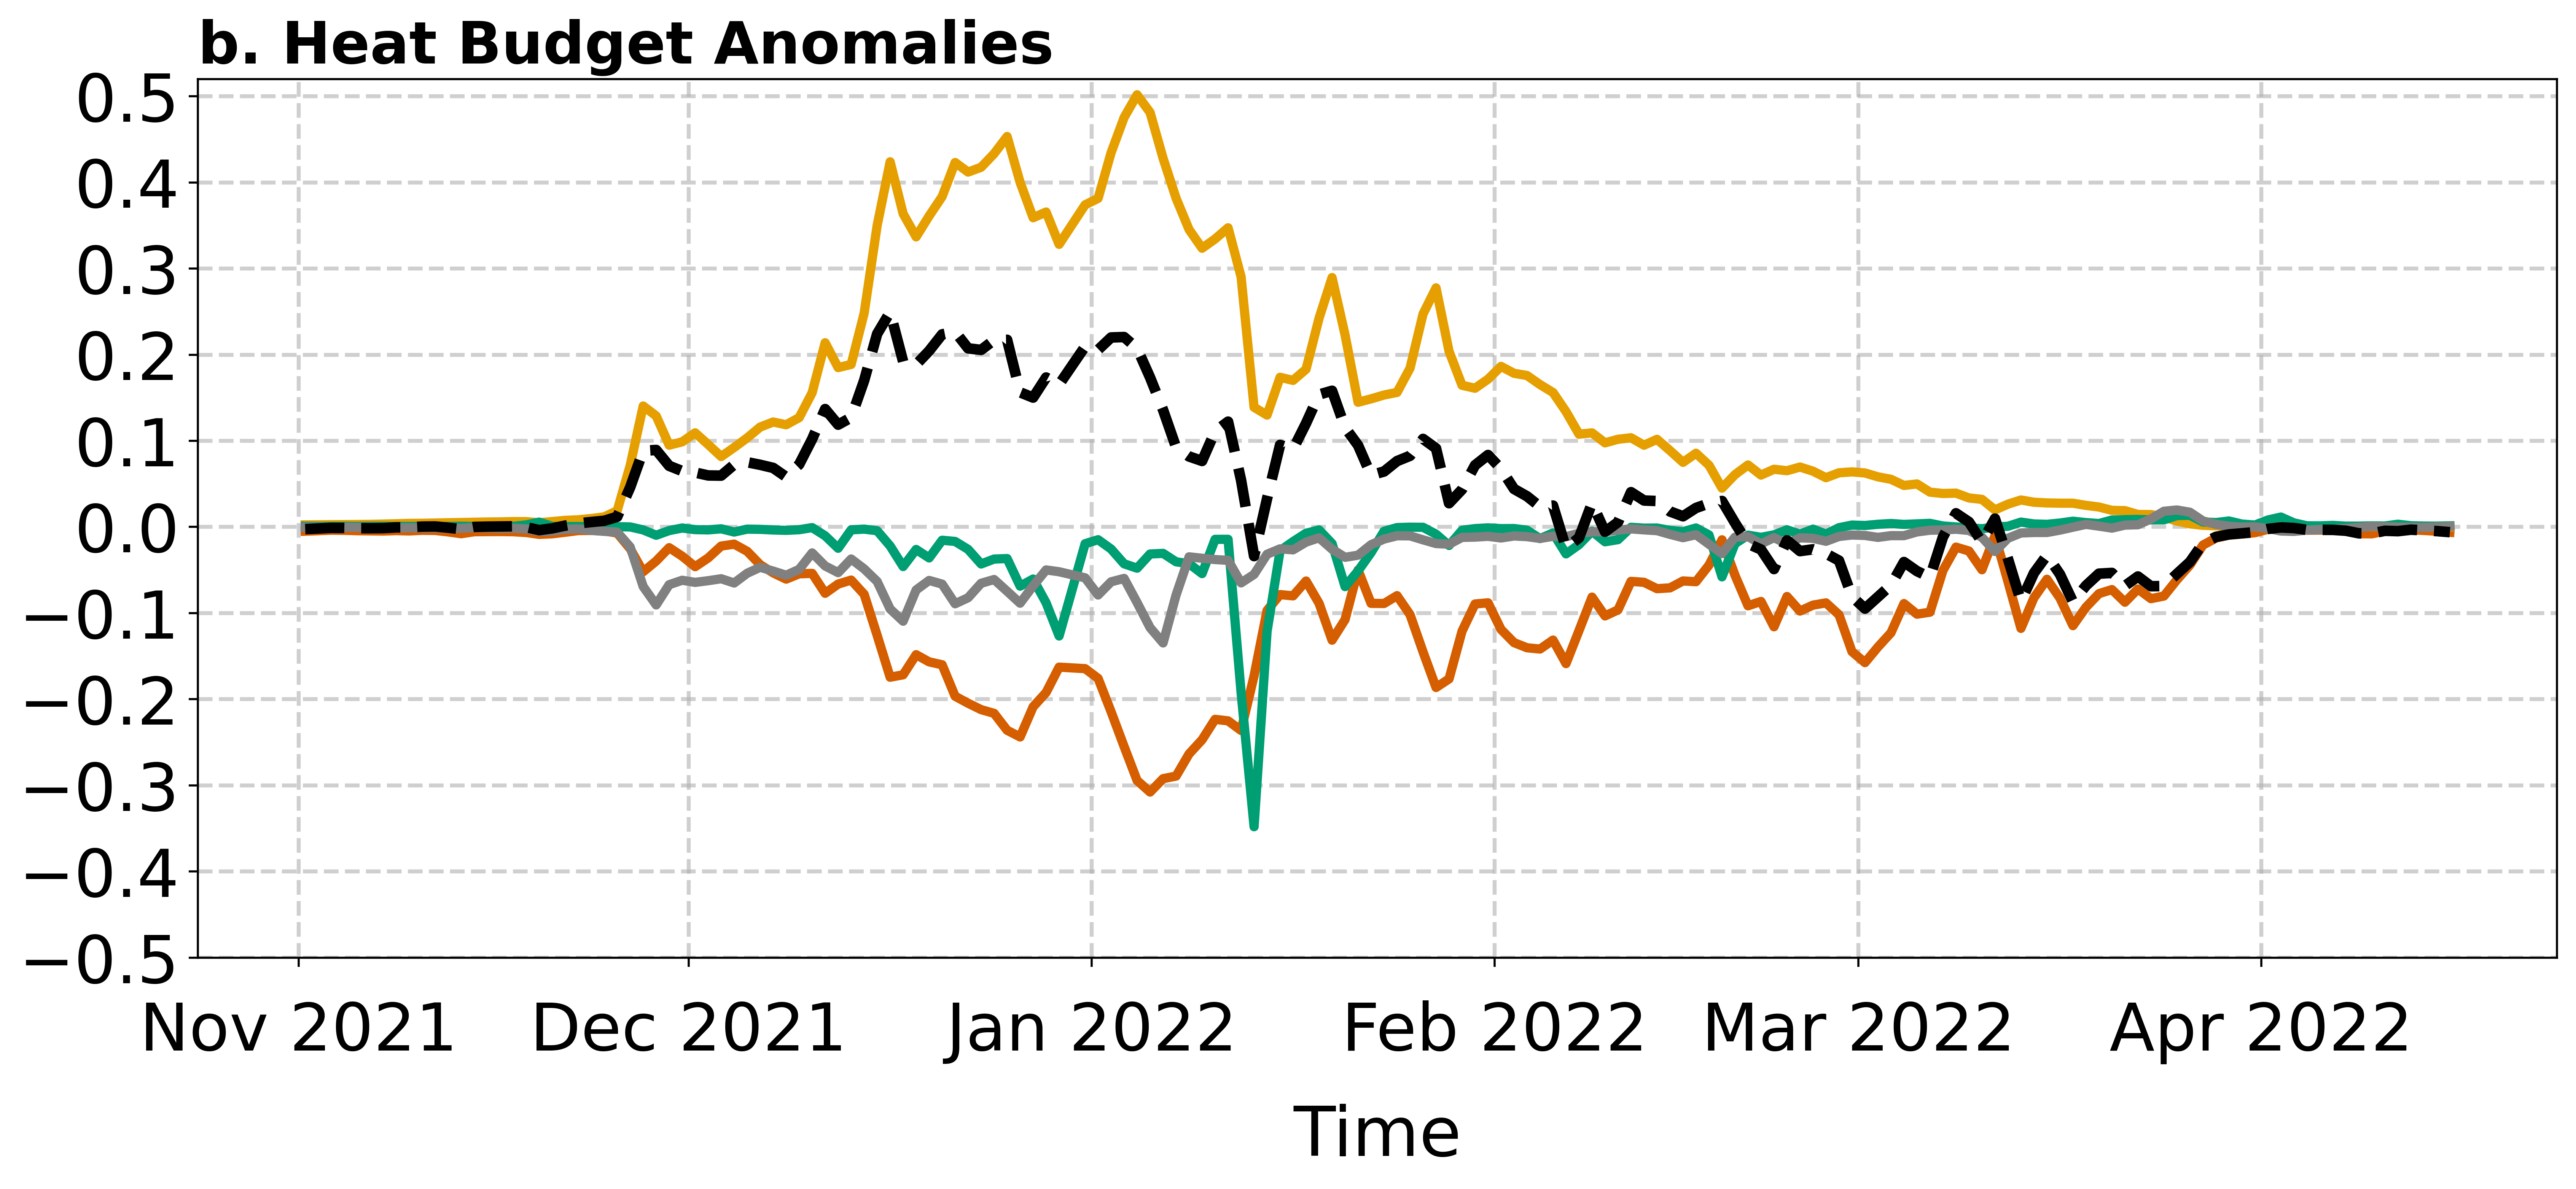

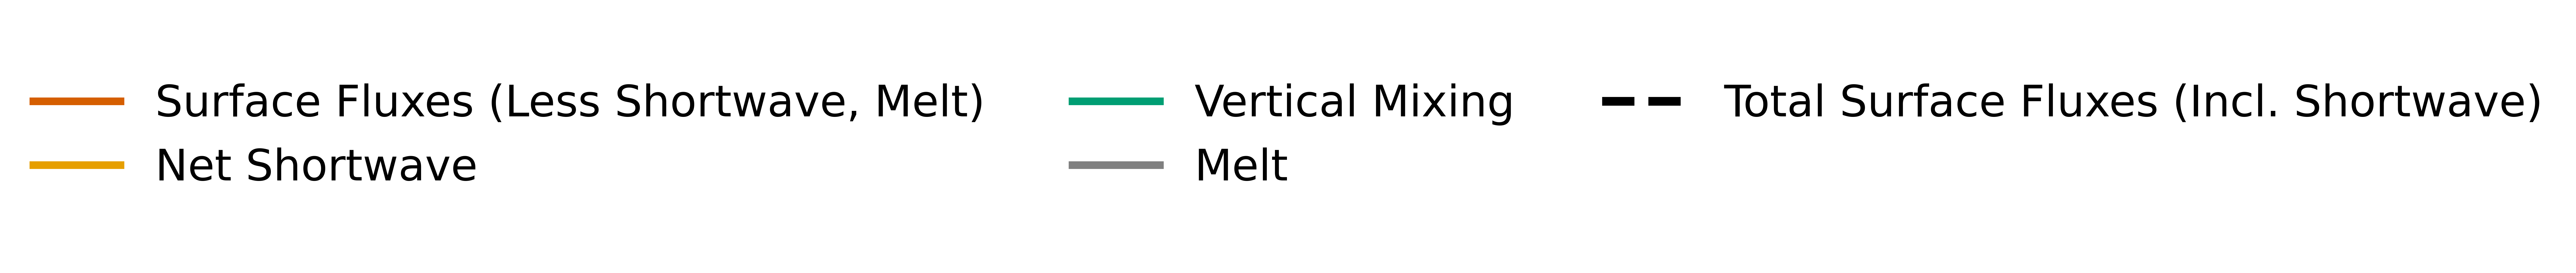

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load your dataset
anom = data_sample.load()  # <--- replace previous 'anom'

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 28,            # 24 + 4
    'axes.labelsize': 26,       # 22 + 4
    'axes.titlesize': 26,       # 22 + 4
    'legend.fontsize': 22,      # 18 + 4
    'xtick.labelsize': 25,      # 20 + 4
    'ytick.labelsize': 25,      # 20 + 4
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 500,
})

# === Figure setup ===
fig, ax = plt.subplots(figsize=(16, 6))

# Dummy twin axis
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.patch.set_alpha(0)
for spine in ax2.spines.values():
    spine.set_visible(False)

unit_conv = 86400  # seconds to °C/day

# --- Select anomaly data slice ---
anom_sample = anom.sel(time=slice('2021-11-01', '2022-04-15')).mean(['xt_ocean','yt_ocean'])

# Variable groups
mlt_tendency = ['mlt_tendency']
air_sea_vars_modified = ['Surface Fluxes Grouped less Shortwave & Mass Fluxes']
shortwave_vars = ['swflx', 'Shortwave Penetration']
mixing = ['Grouped Vertical Mixing']
mass = ['mh_flux']
advection = ['Grouped Advection']

# Color mapping
color_map = {
    'Mixed-Layer Temperature Tendency': '#0072B2',
    'Surface Fluxes (Less Shortwave, Melt)': '#D55E00',
    'Net Shortwave': '#E69F00',
    'Melt': 'grey',
    'Vertical Mixing': '#009E73',
    'Total Surface Fluxes (Incl. Shortwave)': 'black'  # new total line
}

# --- Helper function to sum groups ---
def sum_group(vars_list):
    total = None
    for var in vars_list:
        if var in anom_sample:
            da = anom_sample[var]
            total = da.copy() if total is None else total + da
    return total

# --- Compute grouped sums ---
mlt_tendency_sum = sum_group(mlt_tendency)
surface_sum = sum_group(air_sea_vars_modified)
shortwave_sum = sum_group(shortwave_vars)
mixing_sum = sum_group(mixing)
mass_sum = sum_group(mass)
adv_sum = sum_group(advection)

# Combined total surface flux anomaly (swflx + other surface fluxes)
if shortwave_sum is not None and surface_sum is not None:
    total_flux_sum = shortwave_sum + surface_sum
else:
    total_flux_sum = None

x_coord = 'time' if 'time' in anom_sample.dims else 'dayofyear'

# --- Plotting ---
lines = []
labels = []

# if mlt_tendency_sum is not None:
#     l, = ax.plot(mlt_tendency_sum[x_coord], mlt_tendency_sum * unit_conv,
#                  label='Mixed-Layer Temperature Tendency',
#                  color=color_map['Mixed-Layer Temperature Tendency'], linewidth=3.5)
#     lines.append(l); labels.append(l.get_label())

if surface_sum is not None:
    l, = ax.plot(surface_sum[x_coord], surface_sum * unit_conv,
                 label='Surface Fluxes (Less Shortwave, Melt)',
                 color=color_map['Surface Fluxes (Less Shortwave, Melt)'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if shortwave_sum is not None:
    l, = ax.plot(shortwave_sum[x_coord], shortwave_sum * unit_conv,
                 label='Net Shortwave',
                 color=color_map['Net Shortwave'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if mixing_sum is not None:
    l, = ax.plot(mixing_sum[x_coord], mixing_sum * unit_conv,
                 label='Vertical Mixing',
                 color=color_map['Vertical Mixing'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if mass_sum is not None:
    l, = ax.plot(mass_sum[x_coord], mass_sum * unit_conv,
                 label='Melt',
                 color=color_map['Melt'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

# === Add total surface flux anomaly line ===
if total_flux_sum is not None:
    l, = ax.plot(total_flux_sum[x_coord], total_flux_sum * unit_conv,
                 label='Total Surface Fluxes (Incl. Shortwave)',
                 color=color_map['Total Surface Fluxes (Incl. Shortwave)'],
                 linestyle='--', linewidth=4.0)
    lines.append(l); labels.append(l.get_label())

# --- Titles and labels ---
ax.set_title('b. Heat Budget Anomalies', loc='left', fontweight='bold', fontsize=22)
ax.set_xlabel("Time", labelpad=15)
ax.set_ylim(-0.5, 0.52)
ax.set_yticks(np.arange(-0.5, .51, 0.1))

# --- X-axis formatting ---
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for label in ax.get_xticklabels():
    label.set_y(-0.027)
    label.set_rotation(0)
    label.set_horizontalalignment('center')
    label.set_fontsize(25)

# --- Grid + spines ---
ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.6)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(.8)

# --- Show main plot (without legend) ---
plt.show()

# --- Separate legend figure ---
fig_leg = plt.figure(figsize=(10, 2), dpi=600)
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis("off")
ax_leg.legend(lines, labels, loc="center", ncol=3, frameon=False, fontsize=20)

plt.show()

# --- Save figures ---
fig.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Online_Heat_Budget.png", dpi=600, bbox_inches="tight")
fig_leg.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Online_Heat_Budget_Legend.png", dpi=400, bbox_inches="tight")


## Climatology for Online HB

In [9]:
clim = xr.open_mfdataset('/scratch/e14/ts7341/Climatology_RS.nc')

In [10]:
clim['Grouped Advection'] = clim['temp_adv'] + \
                                   clim['submeso'] + \
                                   clim['neut_diffusion'] + \
                                   clim['neutral_gm'] + \
                                   clim['temp_vdiffuse_k33']

clim['Grouped Vertical Mixing'] = clim['temp_nonlocal_KPP'] + \
                                         clim['temp_vdiffuse_diff_cbt']

clim['Surface Fluxes Grouped'] = clim['temp_rivermix'] + \
                              clim['temp_vdiffuse_sbc'] + \
                              clim['frazil_3d'] + \
                              clim['sfc_hflux_pme']

clim['mh_flux'] = clim['temp_rivermix'] + \
                              clim['temp_vdiffuse_sbc'] + \
                              clim['frazil_3d'] + \
                              clim['sfc_hflux_pme'] - \
                              clim['lw_heat'] - \
                              clim['sens_heat'] - \
                              clim['evap_heat'] - \
                              clim['swflx'] - \
                              clim['sfc_hflux_pme'] - \
                              clim['temp_rivermix']

clim['Surface Fluxes Grouped less Shortwave & Mass Fluxes'] = clim['temp_rivermix'] + \
                              clim['temp_vdiffuse_sbc'] + \
                              clim['frazil_3d'] + \
                              clim['sfc_hflux_pme'] - \
                              clim['mh_flux'] - \
                              clim['swflx']

clim['Surface Fluxes Less SW'] = clim['Surface Fluxes Grouped'] - \
                                        clim['swflx']

clim['Shortwave Penetration'] = clim['sw_heat_in_mld']

clim['Shortwave Penetration'] = clim['sw_heat_in_mld']

clim['Net Shortwave'] = clim['swflx'] + clim['Shortwave Penetration']
#clim.load()

In [11]:
clim_daily = clim.sel(dayofyear=data_sample['time'].dt.dayofyear)
clim_daily = clim_daily.assign_coords(time=data_sample['time'])
clim_daily = clim_daily.sel(yt_ocean = yt_coord, xt_ocean = xt_coord).mean(['xt_ocean', 'yt_ocean']).load()

## Anomalies for Online HB

In [12]:
anom = data_sample - clim_daily
anom = anom.mean(['xt_ocean', 'yt_ocean'])
anom.load()

<xarray.Dataset> Size: 51kB
Dimensions:                                              (time: 211)
Coordinates:
  * time                                                 (time) datetime64[ns] 2kB ...
    dayofyear                                            (time) int64 2kB 303...
Data variables: (12/29)
    fixedh_tendency                                      (time) float64 2kB -...
    temp_adv                                             (time) float64 2kB -...
    submeso                                              (time) float64 2kB 3...
    neut_diffusion                                       (time) float64 2kB 4...
    neutral_gm                                           (time) float64 2kB -...
    temp_vdiffuse_k33                                    (time) float64 2kB 9...
    ...                                                   ...
    Surface Fluxes Grouped                               (time) float64 2kB -...
    Surface Fluxes Less SW                               (time) float64 2kB 3...
    mh_flux                                              (time) float64 2kB 5...
    Surface Fluxes Grouped less Shortwave & Mass Fluxes  (time) float64 2kB -...
    Shortwave Penetration                                (time) float64 2kB 7...
    Net Shortwave                                        (time) float64 2kB -...

In [13]:
anom_sample = anom

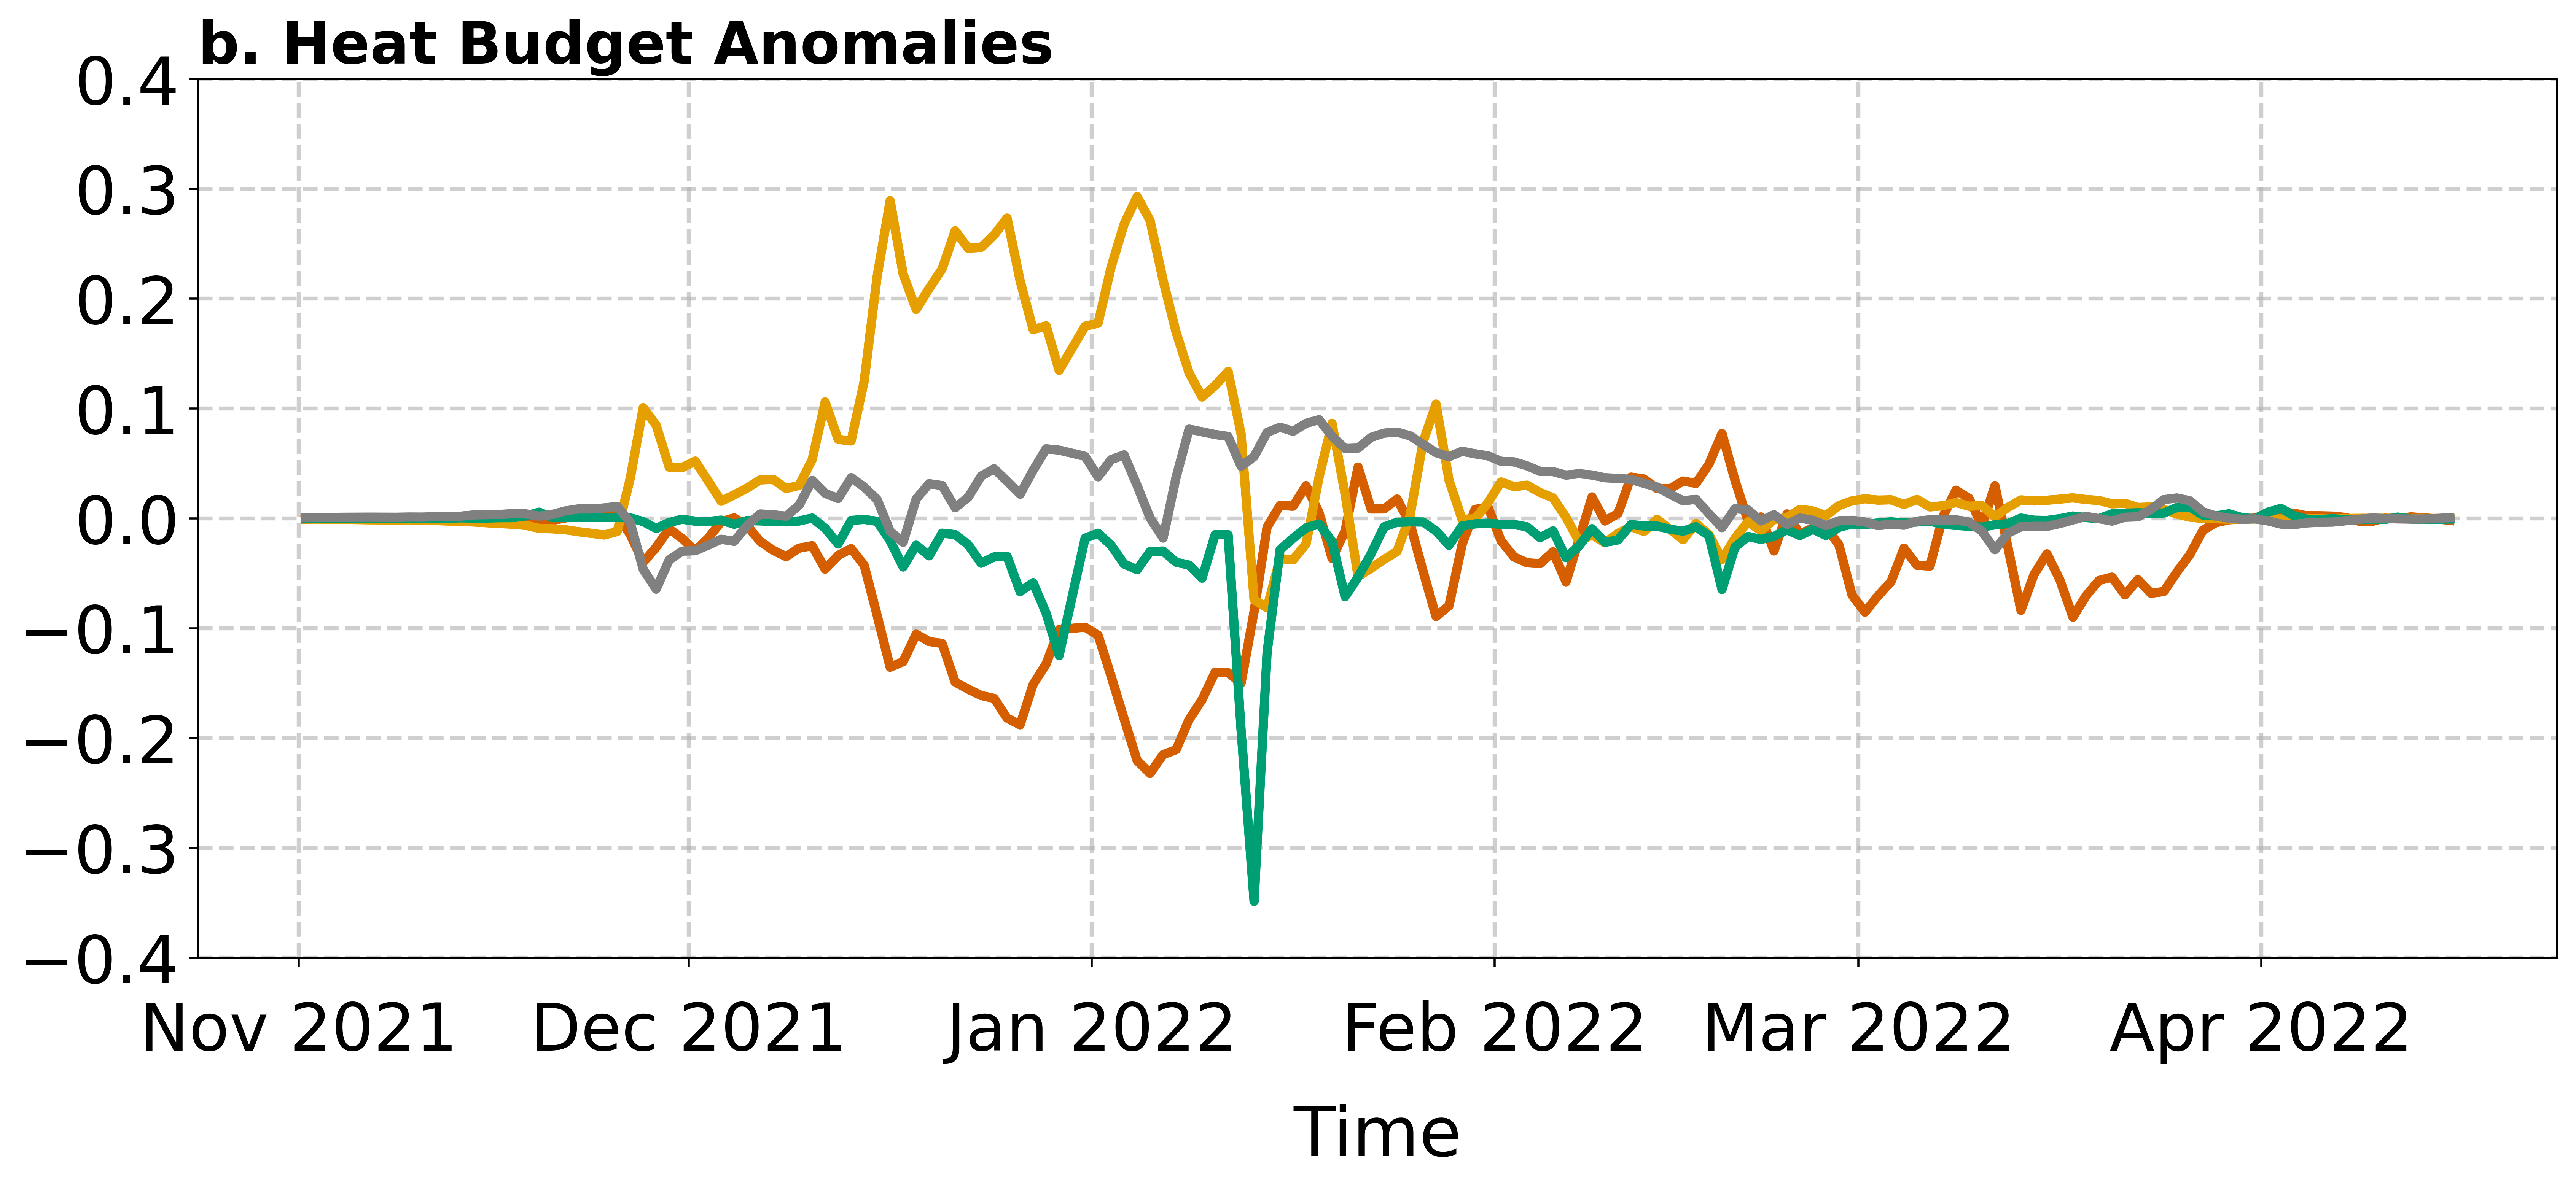

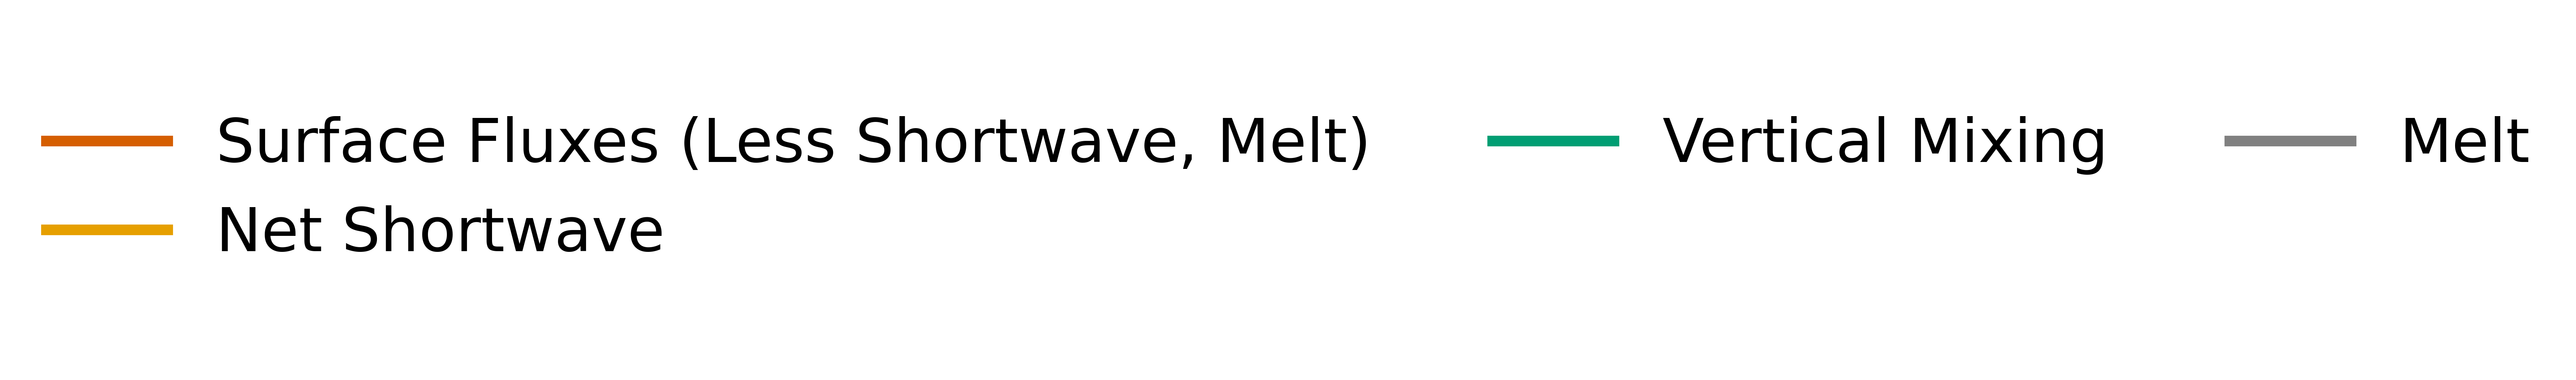

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 28,            # 24 + 4
    'axes.labelsize': 26,       # 22 + 4
    'axes.titlesize': 26,       # 22 + 4
    'legend.fontsize': 22,      # 18 + 4
    'xtick.labelsize': 25,      # 20 + 4
    'ytick.labelsize': 25,      # 20 + 4
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 500,
})



fig, ax = plt.subplots(figsize=(16, 6))

# Dummy twin axis to match shape with other plots
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.patch.set_alpha(0)
for spine in ax2.spines.values():
    spine.set_visible(False)

unit_conv = 86400  # seconds to °C/day

anom_sample = anom.sel(time=slice('2021-11-01', '2022-04-15'))

mlt_tendency = ['mlt_tendency']
air_sea_vars_modified = ['Surface Fluxes Grouped less Shortwave & Mass Fluxes']
shortwave_vars = ['swflx', 'Shortwave Penetration']
mixing = ['Grouped Vertical Mixing']
mass = ['mh_flux']
advection = ['Grouped Advection']

color_map = {
    'Mixed-Layer Temperature Tendency': '#0072B2',
    'Surface Fluxes (Less Shortwave, Melt)': '#D55E00',
    'Net Shortwave': '#E69F00',
    'Melt': 'grey',
    'Vertical Mixing': '#009E73'
}

# sum variables
def sum_group(vars_list):
    total = None
    for var in vars_list:
        if var in anom_sample:
            da = anom_sample[var]
            total = da.copy() if total is None else total + da
    return total

mlt_tendency_sum = sum_group(mlt_tendency)
surface_sum = sum_group(air_sea_vars_modified)
shortwave_sum = sum_group(shortwave_vars)
mixing_sum = sum_group(mixing)
mass_sum = sum_group(mass)
adv_sum = sum_group(advection)

x_coord = 'time' if 'time' in anom_sample.dims else 'dayofyear'

# Plot and collect handles
lines = []
labels = []

# if mlt_tendency_sum is not None:
#     l, = ax.plot(mlt_tendency_sum[x_coord], mlt_tendency_sum * unit_conv,
#                  label='Mixed-Layer Temperature Tendency',
#                  color=color_map['Mixed-Layer Temperature Tendency'], linewidth=3.5)
#     lines.append(l); labels.append(l.get_label())

if surface_sum is not None:
    l, = ax.plot(surface_sum[x_coord], surface_sum * unit_conv,
                 label='Surface Fluxes (Less Shortwave, Melt)',
                 color=color_map['Surface Fluxes (Less Shortwave, Melt)'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if shortwave_sum is not None:
    l, = ax.plot(shortwave_sum[x_coord], shortwave_sum * unit_conv,
                 label='Net Shortwave',
                 color=color_map['Net Shortwave'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if mixing_sum is not None:
    l, = ax.plot(mixing_sum[x_coord], mixing_sum * unit_conv,
                 label='Vertical Mixing',
                 color=color_map['Vertical Mixing'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if mass_sum is not None:
    l, = ax.plot(mass_sum[x_coord], mass_sum * unit_conv,
                 label='Melt',
                 color=color_map['Melt'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

# Titles and labels
ax.set_title('b. Heat Budget Anomalies', loc='left', fontweight='bold', fontsize=22)
ax.set_xlabel("Time", labelpad=15)
# ax.set_ylabel("Heating Rate (°C / day)", labelpad=15)
ax.set_ylim(-0.4, 0.4)
ax.set_yticks(np.arange(-0.4, .41, 0.1))

# X-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for label in ax.get_xticklabels():
    label.set_y(-0.027)
    label.set_rotation(0)
    label.set_horizontalalignment('center')
    label.set_fontsize(25)


# Grid + spines
ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.6)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(.8)

# --- Show main plot (without legend) ---
plt.show()

# --- Separate legend figure ---
fig_leg = plt.figure(figsize=(10, 2),dpi=600)
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis("off")
ax_leg.legend(lines, labels, loc="center", ncol=3, frameon=False, fontsize = 20)

plt.show()

fig.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Online_Heat_Budget.png", dpi=600, bbox_inches="tight")
fig_leg.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Online_Heat_Budget_Legend.png", dpi=400, bbox_inches="tight")


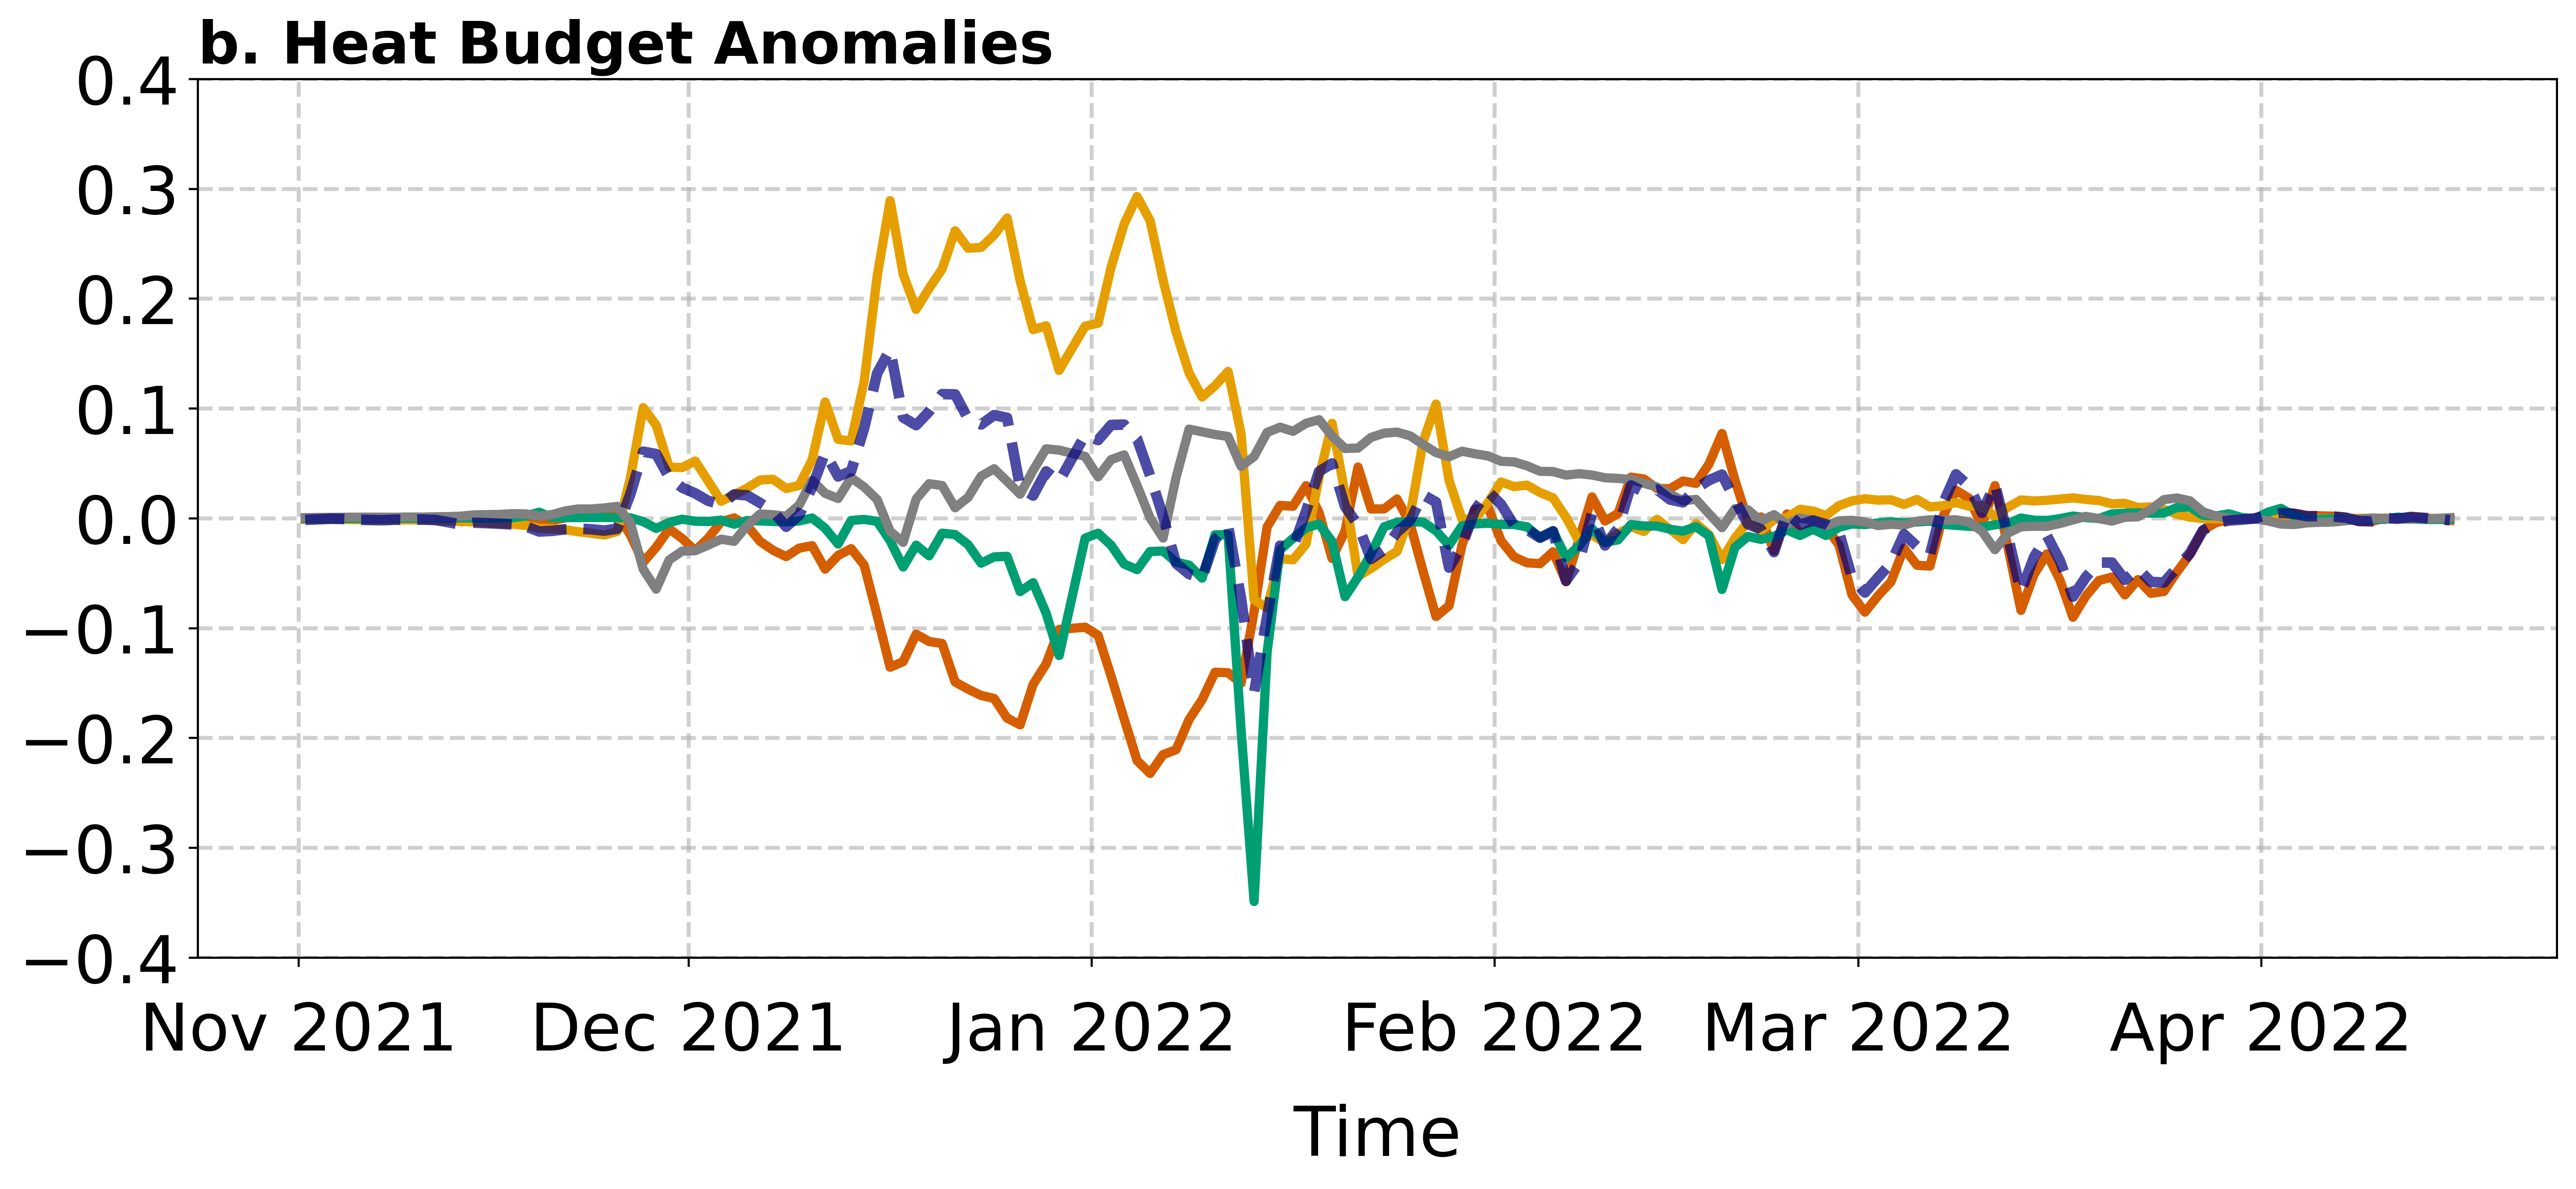

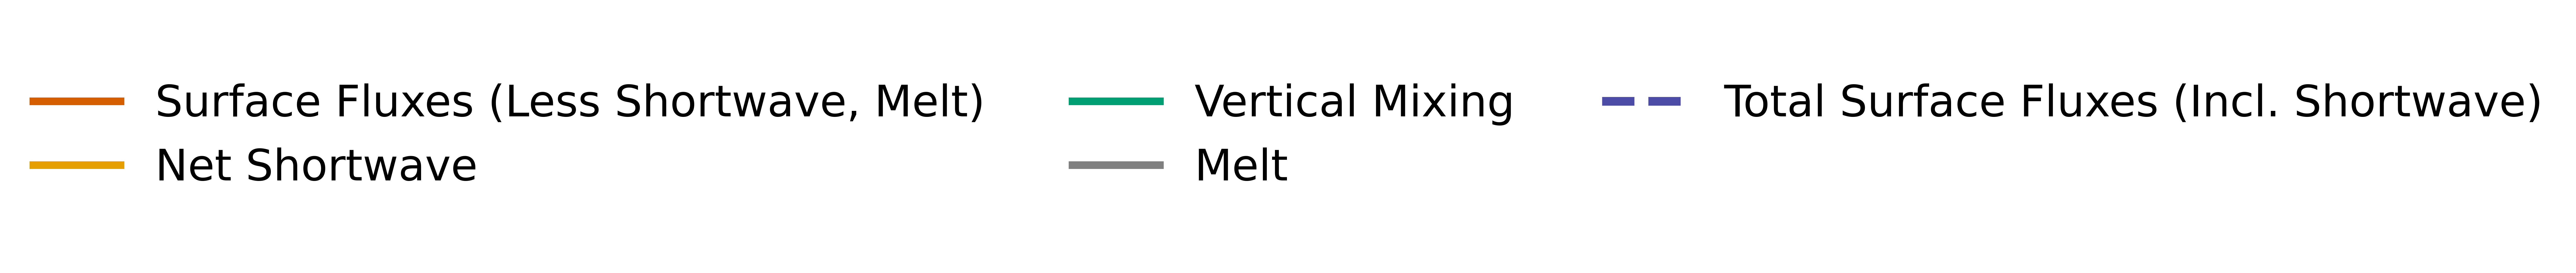

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 28,            # 24 + 4
    'axes.labelsize': 26,       # 22 + 4
    'axes.titlesize': 26,       # 22 + 4
    'legend.fontsize': 22,      # 18 + 4
    'xtick.labelsize': 25,      # 20 + 4
    'ytick.labelsize': 25,      # 20 + 4
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 500,
})

# === Figure setup ===
fig, ax = plt.subplots(figsize=(16, 6))

# Dummy twin axis to match shape with other plots
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.patch.set_alpha(0)
for spine in ax2.spines.values():
    spine.set_visible(False)

unit_conv = 86400  # seconds to °C/day

# --- Select anomaly data (user-provided dataset) ---
anom_sample = anom.sel(time=slice('2021-11-01', '2022-04-15'))

# Variable groups
mlt_tendency = ['mlt_tendency']
air_sea_vars_modified = ['Surface Fluxes Grouped less Shortwave & Mass Fluxes']
shortwave_vars = ['swflx', 'Shortwave Penetration']
mixing = ['Grouped Vertical Mixing']
mass = ['mh_flux']
advection = ['Grouped Advection']

# Color mapping
color_map = {
    'Mixed-Layer Temperature Tendency': '#0072B2',
    'Surface Fluxes (Less Shortwave, Melt)': '#D55E00',
    'Net Shortwave': '#E69F00',
    'Melt': 'grey',
    'Vertical Mixing': '#009E73',
    'Total Surface Fluxes (Incl. Shortwave)': 'black'  # new line
}

# --- Helper function to sum groups ---
def sum_group(vars_list):
    total = None
    for var in vars_list:
        if var in anom_sample:
            da = anom_sample[var]
            total = da.copy() if total is None else total + da
    return total

# --- Compute sums ---
mlt_tendency_sum = sum_group(mlt_tendency)
surface_sum = sum_group(air_sea_vars_modified)
shortwave_sum = sum_group(shortwave_vars)
mixing_sum = sum_group(mixing)
mass_sum = sum_group(mass)
adv_sum = sum_group(advection)

# Combined total surface flux anomaly (swflx + other surface fluxes)
if shortwave_sum is not None and surface_sum is not None:
    total_flux_sum = shortwave_sum + surface_sum
else:
    total_flux_sum = None

x_coord = 'time' if 'time' in anom_sample.dims else 'dayofyear'

# --- Plotting ---
lines = []
labels = []

# Uncomment if you want to include mlt_tendency
# if mlt_tendency_sum is not None:
#     l, = ax.plot(mlt_tendency_sum[x_coord], mlt_tendency_sum * unit_conv,
#                  label='Mixed-Layer Temperature Tendency',
#                  color=color_map['Mixed-Layer Temperature Tendency'], linewidth=3.5)
#     lines.append(l); labels.append(l.get_label())

if surface_sum is not None:
    l, = ax.plot(surface_sum[x_coord], surface_sum * unit_conv,
                 label='Surface Fluxes (Less Shortwave, Melt)',
                 color=color_map['Surface Fluxes (Less Shortwave, Melt)'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if shortwave_sum is not None:
    l, = ax.plot(shortwave_sum[x_coord], shortwave_sum * unit_conv,
                 label='Net Shortwave',
                 color=color_map['Net Shortwave'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if mixing_sum is not None:
    l, = ax.plot(mixing_sum[x_coord], mixing_sum * unit_conv,
                 label='Vertical Mixing',
                 color=color_map['Vertical Mixing'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

if mass_sum is not None:
    l, = ax.plot(mass_sum[x_coord], mass_sum * unit_conv,
                 label='Melt',
                 color=color_map['Melt'], linewidth=3.5)
    lines.append(l); labels.append(l.get_label())

# === Add total surface flux anomaly (swflx + other fluxes) ===
if total_flux_sum is not None:
    l, = ax.plot(total_flux_sum[x_coord], total_flux_sum * unit_conv,
                 label='Total Surface Fluxes (Incl. Shortwave)',
                 color='navy',
                 linestyle='--', linewidth=4.0, alpha = 0.7)
    lines.append(l); labels.append(l.get_label())

# --- Titles and labels ---
ax.set_title('b. Heat Budget Anomalies', loc='left', fontweight='bold', fontsize=22)
ax.set_xlabel("Time", labelpad=15)
ax.set_ylim(-0.4, 0.4)
ax.set_yticks(np.arange(-0.4, .41, 0.1))

# --- X-axis formatting ---
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for label in ax.get_xticklabels():
    label.set_y(-0.027)
    label.set_rotation(0)
    label.set_horizontalalignment('center')
    label.set_fontsize(25)

# --- Grid + spines ---
ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.6)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(.8)

# --- Show main plot (without legend) ---
plt.show()

# --- Separate legend figure ---
fig_leg = plt.figure(figsize=(10, 2), dpi=600)
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis("off")
ax_leg.legend(lines, labels, loc="center", ncol=3, frameon=False, fontsize=20)

plt.show()

# --- Save figures ---
fig.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Online_Heat_Budget.png", dpi=600, bbox_inches="tight")
fig_leg.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Online_Heat_Budget_Legend.png", dpi=400, bbox_inches="tight")


# Offline Reynolds Decomp

## First get surface fluxes loaded in

In [16]:
import cosima_cookbook as cc
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)

time = time_coord
# yt_ocean = yt_coord
# xt_ocean = xt_coord 

clim_time = slice('1982-01-01','2011-12-31')

In [17]:
# Load in data from event
net_sfc_heating = cc.querying.getvar(
    expt='025deg_jra55_iaf_cycle6_online_mlt',
    variable='net_sfc_heating',
    session=session,
    frequency='1 daily',
    attrs={'cell_methods': 'time: mean'},
    chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}
).sel(time = time).\
sel(xt_ocean = xt_coord, yt_ocean = yt_coord)


hflx_sample = net_sfc_heating
hflx_sample = hflx_sample.mean(['xt_ocean', 'yt_ocean'])
hflx_sample.compute()

<xarray.DataArray 'net_sfc_heating' (time: 212)> Size: 848B
array([-3.45052185e+01, -2.40580502e+01, -2.53355484e+01, -2.67612514e+01,
       -2.18849621e+01, -4.47001343e+01, -2.35047512e+01, -8.18466854e+00,
       -7.13869905e+00, -2.08549666e+00, -5.13283062e+00, -3.32917595e+01,
       -2.03635635e+01, -2.60135365e+00, -4.02952099e+00, -3.88074517e+00,
        1.19295865e-01, -6.52538223e+01, -7.04225998e+01, -3.09580536e+01,
        1.81305046e+01,  1.94276638e+01,  2.68332748e+01,  2.79669876e+01,
        3.10819759e+01,  2.79892387e+01,  1.47197266e+01,  2.14837313e+00,
        1.21084042e+01,  1.05781231e+01, -5.99346995e-01,  4.86370945e+00,
        8.95825481e+00,  1.33748055e+01,  1.91361790e+01,  2.75435276e+01,
        4.31681061e+00,  6.88182783e+00,  4.08943291e+01,  5.94670944e+01,
        4.41352043e+01,  5.18439751e+01,  6.96833267e+01,  7.20673294e+01,
        7.60344925e+01,  5.13232651e+01,  4.93949814e+01,  7.02810059e+01,
        7.64324722e+01,  7.47142029e+01,  6.35363388e+01,  6.86079941e+01,
        7.72543335e+01,  8.20701294e+01,  5.78920364e+01,  3.68083992e+01,
        6.99773941e+01,  6.48107376e+01,  7.10905609e+01,  8.75648193e+01,
        8.17954330e+01,  8.17572250e+01,  8.92744980e+01,  8.09734726e+01,
        6.46809311e+01,  4.40067863e+01,  2.70380554e+01,  4.04896164e+01,
        3.97910385e+01,  5.07369232e+01,  6.47963486e+01,  4.95159149e+01,
       -5.70067215e+01, -3.88666458e+01,  5.26658096e+01,  7.01183777e+01,
        7.94425583e+01,  1.16659431e+02,  1.03116402e+02,  7.73266602e+01,
...
       -1.32734024e+02, -7.65849915e+01, -8.96082687e+01, -8.27393341e+01,
       -1.12356392e+02, -9.94092560e+01, -1.20173813e+02, -9.91168365e+01,
       -9.56719208e+01, -5.01556320e+01, -3.11332798e+01, -2.27605820e+01,
       -2.05559406e+01, -1.98705063e+01, -1.32252951e+01, -1.00657644e+01,
       -1.62796955e+01, -1.64143887e+01, -1.79104118e+01, -1.63036251e+01,
       -1.56765728e+01, -1.86044197e+01, -2.39932232e+01, -1.62289429e+01,
       -1.47116957e+01, -1.76982155e+01, -1.18397417e+01, -1.48410845e+01,
       -1.63940945e+01, -1.84216022e+01, -2.20741539e+01, -2.19014149e+01,
       -1.99414768e+01, -2.02865639e+01, -2.10749474e+01, -1.88131104e+01,
       -3.41590843e+01, -2.96237679e+01, -2.19953442e+01, -2.45344048e+01,
       -3.61513863e+01, -3.45390739e+01, -3.07626648e+01, -3.93466187e+01,
       -4.24444160e+01, -3.83677292e+01, -2.15771027e+01, -2.23587723e+01,
       -3.22864494e+01, -3.77557487e+01, -2.95639496e+01, -2.50892334e+01,
       -2.61059990e+01, -2.69707355e+01, -2.07101994e+01, -2.43296566e+01,
       -2.79371490e+01, -2.54437714e+01, -2.33304062e+01, -2.68609428e+01,
       -2.49061699e+01, -1.98172302e+01, -2.19655132e+01, -2.48642788e+01,
       -2.17770004e+01, -3.28950310e+01, -2.56424503e+01, -1.58283615e+01,
       -1.64055576e+01, -1.27948217e+01, -1.72472000e+01, -3.73937073e+01,
       -3.33670769e+01, -3.22054024e+01, -3.12332649e+01, -2.62872276e+01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2021-11-01T12:00:00 ... 2022-05-31T12:...

In [18]:
# Load in data for climatology
net_sfc_heating_clim = cc.querying.getvar(
    expt='025deg_jra55_iaf_cycle6_online_mlt',
    variable='net_sfc_heating',
    session=session,
    frequency='1 daily',
    attrs={'cell_methods': 'time: mean'},
    chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}
).sel(time = clim_time).\
sel(xt_ocean = xt_coord, yt_ocean = yt_coord)

hflx_clim_sample = net_sfc_heating_clim.mean(['xt_ocean','yt_ocean'])
hflx_clim_sample = hflx_clim_sample.compute()

In [19]:
def _to_da(obj, varname=None):
    """
    Return a DataArray from either a DataArray or Dataset.
    If varname is None and obj is a Dataset, pick the first data_var that has 'time' in dims.
    """
    if isinstance(obj, xr.DataArray):
        return obj
    if isinstance(obj, xr.Dataset):
        if varname is not None:
            return obj[varname]
        # pick first var with 'time' in dims
        for v in obj.data_vars:
            if 'time' in obj[v].dims:
                return obj[v]
        # fallback: first variable
        return next(iter(obj.data_vars.values()))
    raise TypeError("Expected xarray DataArray or Dataset")

In [20]:
def smoothedClima_mhw(obj, varname=None, smoothPercentile=True, smoothPercentileWidth=31):
    """
    Climatology (DOY) smoothed with 31-day running mean.
    Accepts DataArray or Dataset. If Dataset, pass varname or the first time-varying var is used.
    Returns a DataArray (same spatial dims, 'dayofyear' dim).
    """
    da = _to_da(obj, varname)
    if "time" not in da.dims:
        raise ValueError("No 'time' dimension found.")

    clim = da.groupby("time.dayofyear").mean()

    # If user requests smoothing:
    if smoothPercentile:
        # For optimized concatenation, create doy vector with just the right amount of time steps
        year = 1996 # Dummy year. The reference year needs to be a leap year
        # Create a pandas datetime of 366 dayof year
        date_doy = pd.to_datetime(clim.dayofyear - 1, unit='D', origin=f'{year}-01-01', errors='coerce')
        # Concat the last 31 days, the whole year and the first 31 days (for datetime vector and for data)
        time_concat = [*(date_doy[-smoothPercentileWidth:]- pd.DateOffset(years=1)), 
                       *date_doy, 
                       *(date_doy[:smoothPercentileWidth] + pd.DateOffset(years=1))]
        stacked = xr.concat([clim.isel(dayofyear=slice(-smoothPercentileWidth,None)), 
                             clim, 
                             clim.isel(dayofyear=slice(None,smoothPercentileWidth))], dim='dayofyear') \
                    .assign_coords({'time':('dayofyear',time_concat)}) \
                    .swap_dims({'dayofyear':'time'})

        # PERF: ensure stacked core dim is single-chunk for rolling
        if hasattr(stacked.data, "chunks"):
            stacked = stacked.chunk({"time": -1})
        # The actual smoothing    
        smoothed = stacked.rolling(time=smoothPercentileWidth, min_periods=1, center=True).mean()
        # Now extract the middle year using this little groupby trick. Another way would be to isel(doy=slice())
        mid_sel = smoothed.groupby('time.year')[1996].swap_dims({'time':'dayofyear'}).drop_vars('time')
        # Make sure the names are right
        out = mid_sel.rename({'time':'dayofyear'}) if 'time' in mid_sel.dims else mid_sel
    else: # If no smoothing
        out = clim
    return out.assign_coords(dayofyear=clim.dayofyear.data)


In [21]:
hflx_clim = smoothedClima_mhw(hflx_clim_sample) 

In [22]:
hflx_clim_daily = hflx_clim.sel(dayofyear=hflx_sample['time'].dt.dayofyear)
hflx_clim_daily = hflx_clim_daily.assign_coords(time=hflx_sample['time'])
hflx_clim_daily.compute()

<xarray.DataArray 'net_sfc_heating' (time: 212)> Size: 848B
array([-13.582434  , -12.856092  , -12.1571245 , -11.4132805 ,
       -10.561753  ,  -9.653925  ,  -8.866666  ,  -8.002253  ,
        -7.1290145 ,  -6.2434635 ,  -5.4288216 ,  -4.7097254 ,
        -3.8799107 ,  -2.9796102 ,  -2.157407  ,  -1.3497542 ,
        -0.45865163,   0.46561676,   1.3754605 ,   2.30564   ,
         3.2018359 ,   4.1320734 ,   4.9848456 ,   5.827659  ,
         6.535847  ,   7.0643053 ,   7.5355954 ,   7.9998474 ,
         8.501657  ,   9.089874  ,   9.627105  ,   9.969103  ,
        10.424505  ,  10.92277   ,  11.427728  ,  11.816269  ,
        12.00721   ,  12.383669  ,  12.72571   ,  12.997038  ,
        13.316748  ,  13.702882  ,  14.229125  ,  14.755561  ,
        15.240119  ,  15.711482  ,  15.914143  ,  16.20568   ,
        16.588745  ,  16.980837  ,  17.362803  ,  17.750202  ,
        18.117266  ,  18.628317  ,  19.029642  ,  19.355343  ,
        19.700325  ,  20.001307  ,  20.221575  ,  20.489098  ,
        20.741755  ,  20.988274  ,  21.121092  ,  21.201277  ,
        21.400625  ,  21.601625  ,  21.979551  ,  21.993322  ,
        21.841372  ,  21.776823  ,  21.765966  ,  21.637243  ,
        21.160528  ,  20.68364   ,  20.187426  ,  19.755686  ,
        19.307789  ,  18.56704   ,  17.939146  ,  17.240946  ,
...
       -22.54503   , -21.783302  , -20.858112  , -20.241102  ,
       -19.532663  , -18.852848  , -18.128534  , -17.421526  ,
       -16.838148  , -16.099491  , -15.276633  , -14.457972  ,
       -13.988366  , -13.692055  , -13.482369  , -13.275226  ,
       -13.259758  , -13.28401   , -13.309091  , -13.310908  ,
       -13.3012085 , -13.315458  , -13.383489  , -13.427346  ,
       -13.523226  , -13.4885845 , -13.56747   , -13.626879  ,
       -13.669257  , -13.735598  , -13.833268  , -13.975786  ,
       -14.088786  , -14.254508  , -14.448279  , -14.596668  ,
       -14.725876  , -14.796111  , -14.892658  , -15.016129  ,
       -15.132788  , -15.319515  , -15.542006  , -15.798358  ,
       -16.027678  , -16.294104  , -16.574238  , -16.772268  ,
       -17.047506  , -17.327757  , -17.632227  , -17.859684  ,
       -18.118124  , -18.292723  , -18.462885  , -18.60968   ,
       -18.80191   , -18.973454  , -19.31364   , -19.635061  ,
       -19.99282   , -20.298546  , -20.572905  , -20.778547  ,
       -20.961374  , -21.090704  , -21.275812  , -21.565449  ,
       -21.97082   , -22.16754   , -22.441427  , -22.771172  ,
       -23.027033  , -23.2468    , -23.362547  , -23.465866  ],
      dtype=float32)
Coordinates:
    dayofyear  (time) int64 2kB 305 306 307 308 309 310 ... 147 148 149 150 151
  * time       (time) datetime64[ns] 2kB 2021-11-01T12:00:00 ... 2022-05-31T1...

## Next load in Daily Averaged MLD

In [23]:
mld_sample = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}).\
                          sel(time = time_coord).\
                          sel(xt_ocean = xt_coord, yt_ocean = yt_coord)

mld_sample = mld_sample.mean(['xt_ocean', 'yt_ocean'])
mld_sample.compute()

<xarray.DataArray 'mld' (time: 212)> Size: 848B
array([1288.4594   , 1287.0344   , 1289.8644   , 1292.4059   ,
       1292.1835   , 1297.7777   , 1235.334    , 1181.7854   ,
       1157.2157   , 1114.6443   , 1071.5989   , 1049.728    ,
       1035.2961   , 1027.8463   ,  976.7518   ,  888.97125  ,
        831.97363  ,  827.8008   ,  781.1531   ,  639.7389   ,
        498.81326  ,  326.74414  ,  217.17155  ,  154.41212  ,
        110.858986 ,   57.704834 ,   15.36588  ,   38.17117  ,
         35.789825 ,   25.870506 ,   24.11653  ,   23.876686 ,
         22.016066 ,   17.531588 ,   17.146769 ,   18.925999 ,
         20.025517 ,   20.924778 ,   21.418253 ,   18.97948  ,
         18.055822 ,   18.82679  ,   16.630997 ,   12.479989 ,
          9.506286 ,    9.37637  ,   11.753008 ,   11.704651 ,
         10.194132 ,    7.858456 ,    8.323955 ,    8.849039 ,
          8.850262 ,    7.977041 ,    7.940712 ,    9.897312 ,
         10.383228 ,   10.779951 ,    9.914522 ,    9.950509 ,
          9.096341 ,    8.68262  ,    7.90265  ,    7.1343412,
          7.223962 ,    7.6403923,    9.224133 ,   10.944728 ,
         11.438217 ,   11.790979 ,   11.3992815,   11.187339 ,
         16.168032 ,   22.287436 ,   22.391    ,   21.51992  ,
         20.822542 ,   18.7921   ,   15.602722 ,   13.086946 ,
...
         30.775497 ,   30.886015 ,   31.139767 ,   31.69749  ,
         32.397854 ,   32.893665 ,   33.711315 ,   34.883038 ,
         37.004654 ,   39.848476 ,   42.357178 ,   45.02695  ,
         48.063686 ,   50.02332  ,   51.44711  ,   53.71988  ,
         56.8162   ,   58.124126 ,   58.555088 ,   59.091213 ,
         59.77257  ,   60.407383 ,   61.20773  ,   62.185825 ,
         63.029266 ,   64.49838  ,   65.13884  ,   65.64585  ,
         66.2955   ,   67.18524  ,   68.640114 ,   70.14715  ,
         71.28502  ,   72.63008  ,   74.12609  ,   75.36163  ,
         78.774    ,   82.83013  ,   83.615585 ,   84.46677  ,
         85.49108  ,   86.30418  ,   87.09062  ,   88.51577  ,
         91.74683  ,   94.37161  ,   95.271774 ,   95.83754  ,
         96.36579  ,   97.44284  ,   98.41831  ,   98.99877  ,
         99.37011  ,   99.78302  ,  100.3599   ,  100.96996  ,
        101.60674  ,  102.54642  ,  103.11254  ,  103.5616   ,
        104.194016 ,  104.80765  ,  105.457344 ,  106.13238  ,
        106.9853   ,  108.134026 ,  109.94548  ,  110.26595  ,
        110.26351  ,  109.99496  ,  109.64663  ,  109.70249  ,
        109.879074 ,  109.92116  ,  109.83152  ,  109.66855  ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2021-11-01T12:00:00 ... 2022-05-31T12:...

In [24]:
mld_clim_sample = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}).\
                          sel(time = clim_time).\
                          sel(xt_ocean = xt_coord, yt_ocean = yt_coord)

mld_clim_sample = mld_clim_sample.mean(['xt_ocean', 'yt_ocean']).load()

In [25]:
mld_clim = smoothedClima_mhw(mld_clim_sample) 

In [26]:
mld_clim_daily = mld_clim.sel(dayofyear=mld_sample['time'].dt.dayofyear)
mld_clim_daily = mld_clim_daily.assign_coords(time=mld_sample['time'])
mld_clim_daily.load()

<xarray.DataArray 'mld' (time: 212)> Size: 848B
array([153.42432  , 152.36072  , 151.19095  , 149.91264  , 148.54584  ,
       146.97565  , 145.40634  , 143.81854  , 142.02623  , 139.95421  ,
       137.71146  , 135.39427  , 133.00995  , 130.54008  , 127.98118  ,
       125.36039  , 122.66509  , 119.80661  , 116.709114 , 113.34433  ,
       109.72494  , 105.97986  , 102.03946  ,  97.96925  ,  93.86462  ,
        89.73613  ,  85.66661  ,  81.696365 ,  77.73514  ,  73.731995 ,
        69.8277   ,  66.004654 ,  62.335606 ,  58.724735 ,  55.21043  ,
        51.751156 ,  48.501453 ,  45.26185  ,  42.030666 ,  39.016796 ,
        36.280266 ,  33.697052 ,  31.207355 ,  28.792212 ,  26.45963  ,
        24.22162  ,  22.037132 ,  20.009615 ,  18.175611 ,  16.607431 ,
        15.339378 ,  14.313112 ,  13.395168 ,  12.663489 ,  12.0733185,
        11.567842 ,  11.155186 ,  10.787784 ,  10.45319  ,  10.206827 ,
        10.0814495,   9.922499 ,   9.876213 ,   9.867974 ,   9.851528 ,
         9.857897 ,   9.856637 ,   9.846442 ,   9.852201 ,   9.853328 ,
         9.851075 ,   9.864838 ,   9.893573 ,   9.942563 ,  10.00251  ,
        10.064941 ,  10.170798 ,  10.212776 ,  10.253927 ,  10.32872  ,
        10.430177 ,  10.568127 ,  10.725785 ,  10.89734  ,  11.085088 ,
        11.275808 ,  11.460008 ,  11.649532 ,  11.841312 ,  12.034602 ,
        12.236838 ,  12.445606 ,  12.652528 ,  12.85899  ,  13.076681 ,
        13.321211 ,  13.583305 ,  13.848224 ,  14.123759 ,  14.404125 ,
...
        19.849901 ,  20.292067 ,  20.756226 ,  21.241474 ,  21.742626 ,
        22.268309 ,  22.819218 ,  23.386992 ,  23.974684 ,  24.574984 ,
        25.191038 ,  25.82266  ,  26.473299 ,  27.139355 ,  27.816711 ,
        28.508316 ,  29.223001 ,  29.95412  ,  30.705593 ,  31.497778 ,
        32.316708 ,  33.153103 ,  34.003    ,  34.868813 ,  35.75016  ,
        36.646854 ,  37.563633 ,  38.496826 ,  39.455208 ,  40.435394 ,
        41.429695 ,  42.436028 ,  43.451    ,  44.473534 ,  45.49951  ,
        46.522022 ,  47.54326  ,  48.560028 ,  49.577957 ,  50.59416  ,
        51.619278 ,  52.64857  ,  53.682583 ,  54.72941  ,  55.78638  ,
        56.85054  ,  57.920223 ,  58.99312  ,  60.065857 ,  61.131264 ,
        62.178432 ,  63.219208 ,  64.262825 ,  65.30613  ,  66.35311  ,
        67.40732  ,  68.465904 ,  69.51192  ,  70.542885 ,  71.553665 ,
        72.54948  ,  73.530914 ,  74.50164  ,  75.472916 ,  76.44295  ,
        77.41071  ,  78.384125 ,  79.35267  ,  80.310394 ,  81.26537  ,
        82.2232   ,  83.178    ,  84.12376  ,  85.0761   ,  86.00854  ,
        86.919304 ,  87.81415  ,  88.69539  ,  89.559296 ,  90.41811  ,
        91.265785 ,  92.104904 ,  92.938965 ,  93.76081  ,  94.57086  ,
        95.35946  ,  96.12042  ,  96.86188  ,  97.59574  ,  98.32756  ,
        99.049034 ,  99.754585 , 100.44647  , 101.13025  , 101.79675  ,
       102.446    , 103.07933  ], dtype=float32)
Coordinates:
    dayofyear  (time) int64 2kB 305 306 307 308 309 310 ... 147 148 149 150 151
  * time       (time) datetime64[ns] 2kB 2021-11-01T12:00:00 ... 2022-05-31T1...

## Perform decomposition

In [27]:
# -----------------------------
# Reynolds Decomposition Logic
# -----------------------------
%matplotlib inline
rho0 = 1035.
Cp = 3992.10322329649

def reynolds_decompose(Q_2023, Q_clim, H_2023, H_clim):
    """Apply Reynolds decomposition to heat terms, see Appendix D."""
    Q_anom = Q_2023 - Q_clim
    invH_2023 = 1 / H_2023
    invH_clim = 1 / H_clim
    invH_anom = invH_2023 - invH_clim

    # Decomposition terms
    QoverH = Q_2023 / H_2023
    Qbar_1ovrHbar = Q_clim / H_clim
    Qprime_1ovrHbar = Q_anom * invH_clim
    Qbar_1ovrHprime = Q_clim * invH_anom
    Qprime_1ovrHprime = Q_anom * invH_anom

    Residual = QoverH - (Qbar_1ovrHbar + Qprime_1ovrHbar + Qbar_1ovrHprime + Qprime_1ovrHprime)
    
    # Time mean of covariant term
    Qprime_1ovrHprime_mean = np.mean(Qprime_1ovrHprime, axis=0)

    # Corrected climatological Qsurf 
    Qbar_corrected = Qbar_1ovrHbar + Qprime_1ovrHprime_mean

    #ANOMALOUS ANOMALY
    Qprime_1ovrHprime_anom = Qprime_1ovrHprime - Qprime_1ovrHprime.mean(dim='time')

    Residual_corrected = QoverH - (Qbar_corrected + Qprime_1ovrHbar + 
                                   Qbar_1ovrHprime + Qprime_1ovrHprime_anom)

    return {
        "QoverH": QoverH,
        "Qbar_1ovrHbar": Qbar_1ovrHbar,
        "Qprime_1ovrHbar": Qprime_1ovrHbar,
        "Qbar_1ovrHprime": Qbar_1ovrHprime,
        "Qprime_1ovrHprime": Qprime_1ovrHprime,
        "Qprime_1ovrHprime_mean": Qprime_1ovrHprime_mean,
        "Qbar_corrected": Qbar_corrected,
        "Qprime_1ovrHprime_anom": Qprime_1ovrHprime_anom,
        "Residual": Residual,
        "Residual_Corrected": Residual_corrected
    }

Q_2023 = hflx_sample
Q_clim = hflx_clim_daily

H_2023 = mld_sample
H_clim = mld_clim_daily

results = reynolds_decompose(Q_2023, Q_clim, H_2023, H_clim)

ds_reynolds = xr.Dataset({
    "QoverH": results["QoverH"],
    "Qbar_1ovrHbar": results["Qbar_1ovrHbar"],
    "Qprime_1ovrHbar": results["Qprime_1ovrHbar"],
    "Qbar_1ovrHprime": results["Qbar_1ovrHprime"],
    "Qprime_1ovrHprime": results["Qprime_1ovrHprime"],
    "Residual": results["Residual"],
    "Residual_Corrected": results["Residual_Corrected"],
})

ds_reynolds = ds_reynolds/rho0/Cp*3600*24
ds_reynolds = ds_reynolds.sel(time = time)
ds_reynolds.compute()

<xarray.Dataset> Size: 9kB
Dimensions:             (time: 212)
Coordinates:
  * time                (time) datetime64[ns] 2kB 2021-11-01T12:00:00 ... 202...
    dayofyear           (time) int64 2kB 305 306 307 308 309 ... 148 149 150 151
Data variables:
    QoverH              (time) float32 848B -0.00056 -0.0003909 ... -0.005012
    Qbar_1ovrHbar       (time) float32 848B -0.001851 -0.001764 ... -0.00476
    Qprime_1ovrHbar     (time) float32 848B -0.002852 -0.001537 ... -0.0005723
    Qbar_1ovrHprime     (time) float32 848B 0.001631 0.001556 ... 0.000286
    Qprime_1ovrHprime   (time) float32 848B 0.002512 0.001355 ... 3.439e-05
    Residual            (time) float32 848B 3.895e-10 -7.79e-11 ... -6.232e-10
    Residual_Corrected  (time) float32 848B 7.79e-11 7.79e-11 ... 0.0 -3.116e-10

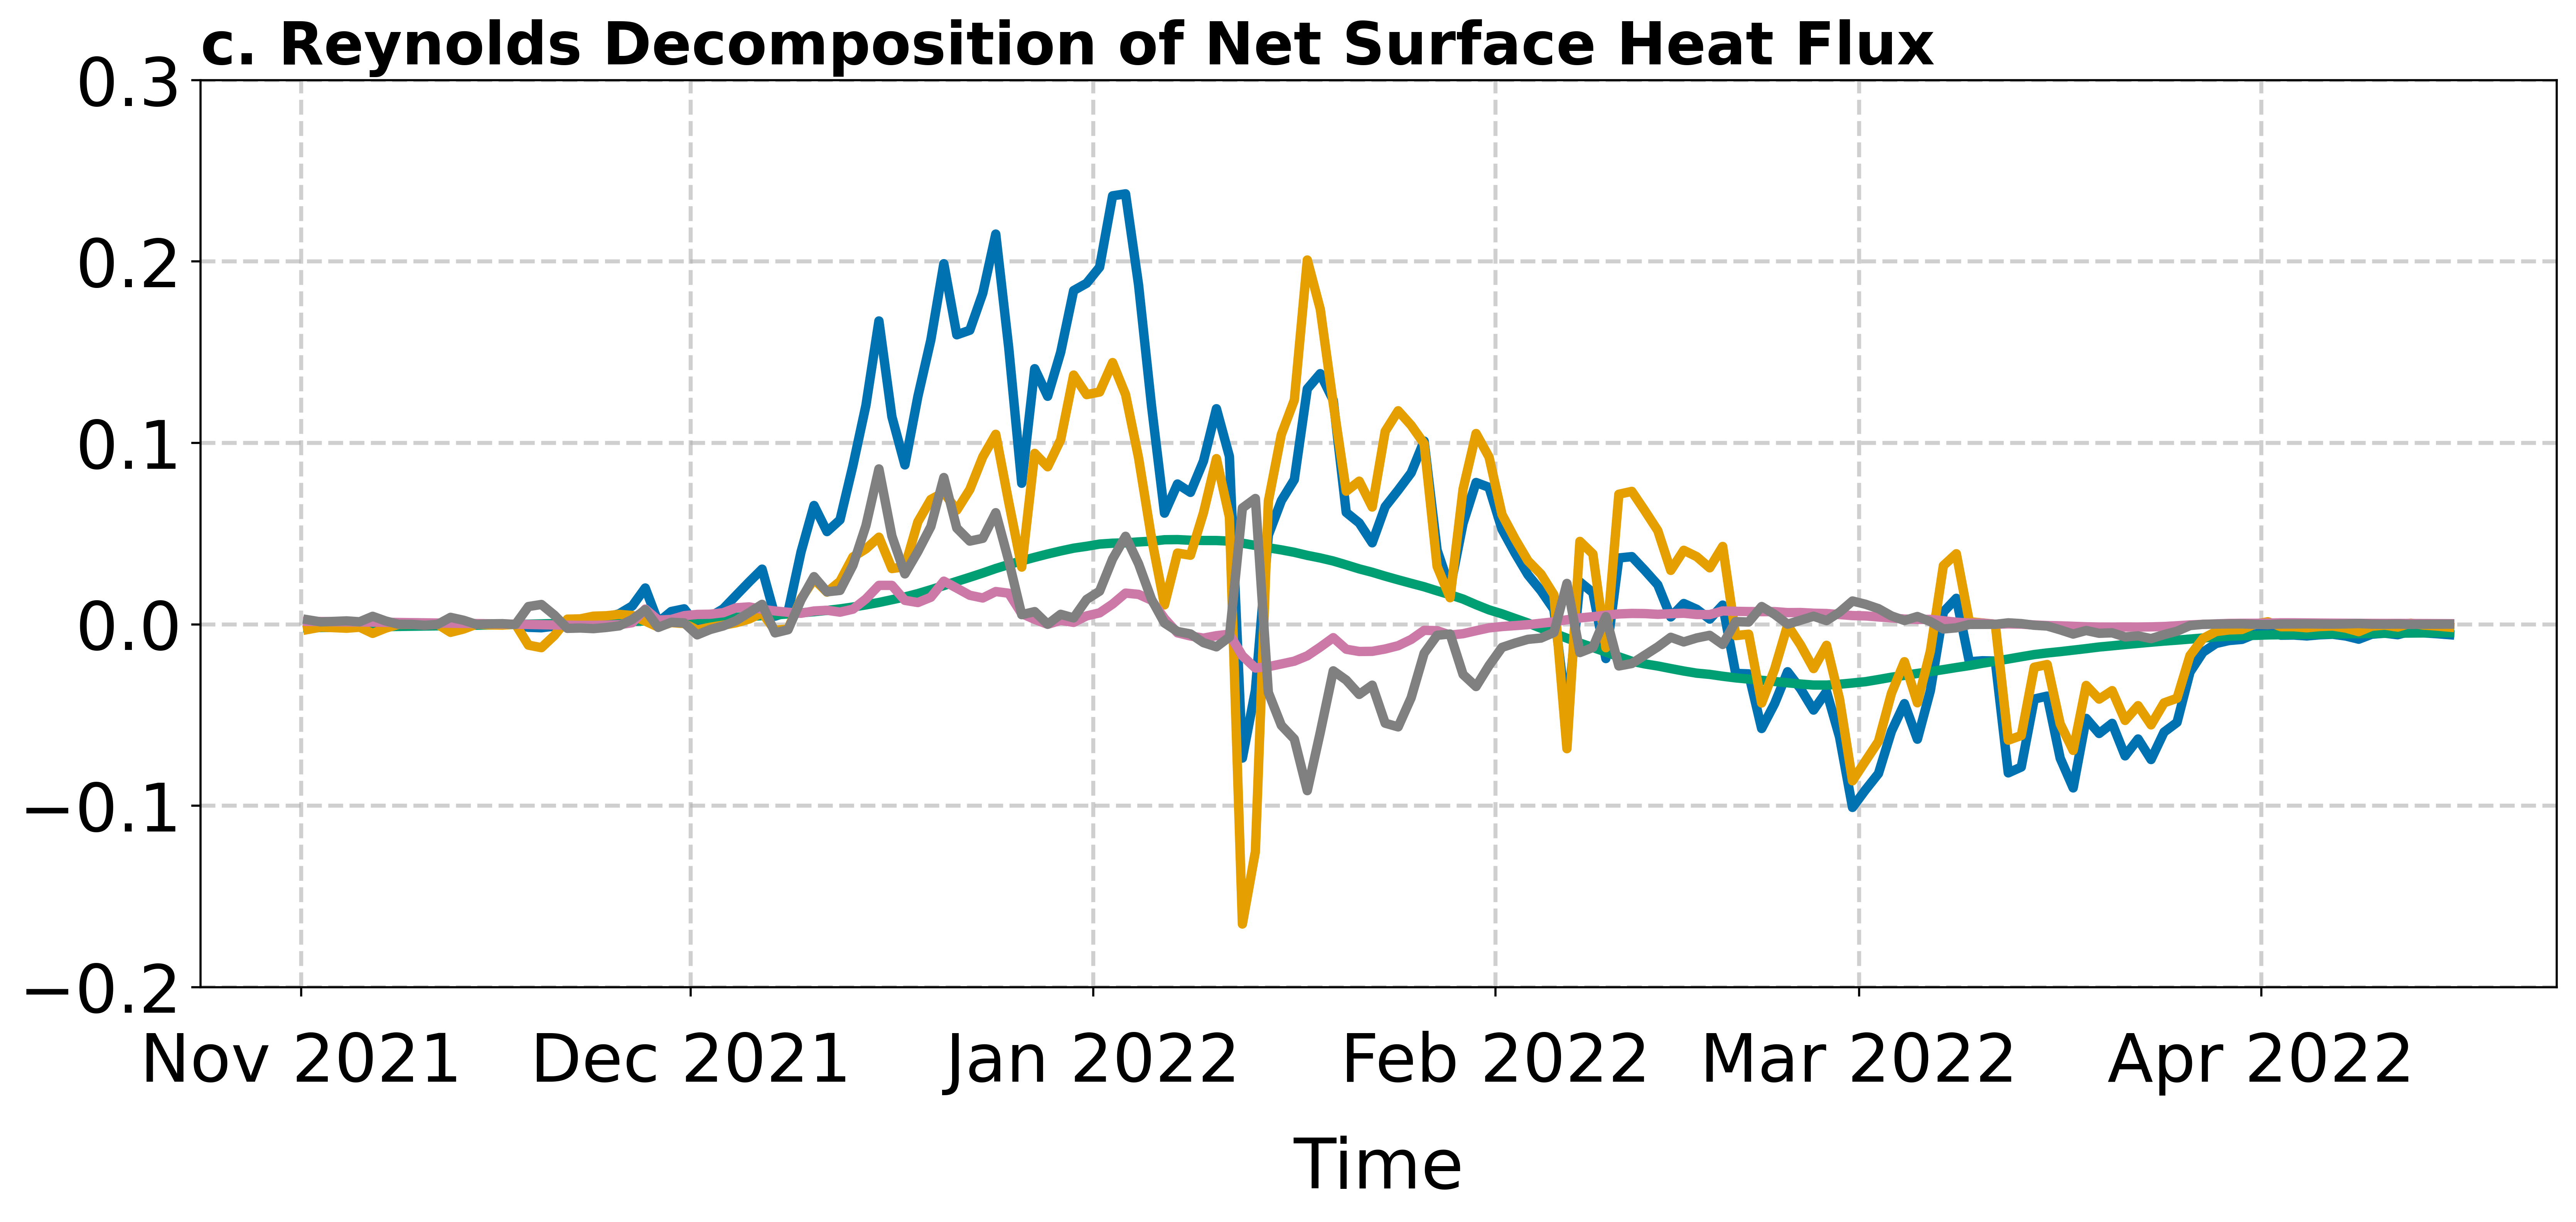

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

plot_terms = [
    'QoverH',
    'Qbar_1ovrHbar',
    'Qprime_1ovrHbar',
    'Qbar_1ovrHprime',
    'Qprime_1ovrHprime'
]

term_labels = {
    "QoverH": r"$Q/H$",
    "Qbar_1ovrHbar": r"$\overline{Q}/\overline{H}$",
    "Qprime_1ovrHbar": r"$Q'/\overline{H}$",
    "Qbar_1ovrHprime": r"$\overline{Q}/H'$",
    "Qprime_1ovrHprime": r"$Q'/H'$",
}

ds_aligned = ds_reynolds[plot_terms]
ds_plot = ds_aligned.sel(time=slice('2021-11-01', '2022-04-15'))
df_plot = ds_plot.to_array(name="value", dim="Variable").to_dataframe().reset_index()
df_plot['Variable'] = df_plot['Variable'].map(term_labels)

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 28,            # 24 + 4
    'axes.labelsize': 26,       # 22 + 4
    'axes.titlesize': 26,       # 22 + 4
    'legend.fontsize': 22,      # 18 + 4
    'xtick.labelsize': 2,      # 20 + 4
    'ytick.labelsize': 25,      # 20 + 4
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 500,
})


# Main figure
fig, ax = plt.subplots(figsize=(14, 7))

color_map_cb = {
    r"$Q/H$": '#0072B2',
    r"$\overline{Q}/\overline{H}$": '#009E73',
    r"$Q'/\overline{H}$": '#E69F00',
    r"$\overline{Q}/H'$": '#CC79A7',
    r"$Q'/H'$": 'grey'
}

for var in df_plot['Variable'].unique():
    subset = df_plot[df_plot['Variable'] == var]
    ax.plot(subset['time'], subset['value'], label=var,
            color=color_map_cb.get(var, 'black'), linewidth=3.5)

ax.set_title("c. Reynolds Decomposition of Net Surface Heat Flux", fontsize=22, loc='left', fontweight='bold')
ax.set_xlabel("Time", labelpad=15)

ax.set_ylim(-0.2, 0.3)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for label in ax.get_xticklabels():
    label.set_y(-0.027)
    label.set_rotation(0)
    label.set_fontsize(25)
    label.set_horizontalalignment('center')

ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.6)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(.8)

# Dummy twin axis
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.patch.set_alpha(0)
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

# # Separate legend figure
# fig_leg = plt.figure(figsize=(10, 2), dpi=400)
# leg = fig_leg.legend(handles=ax.get_lines(),
#                      labels=[l.get_label() for l in ax.get_lines()],
#                      loc='center', ncol=5, frameon=False, fontsize=20)
# plt.axis('off')
# plt.tight_layout()

fig.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Reynolds_Decomp.png", dpi=400, bbox_inches="tight")
# fig_leg.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Weddell_Sea_Reynolds_Decomp_Legend.png", dpi=400, bbox_inches="tight")

# plt.show()


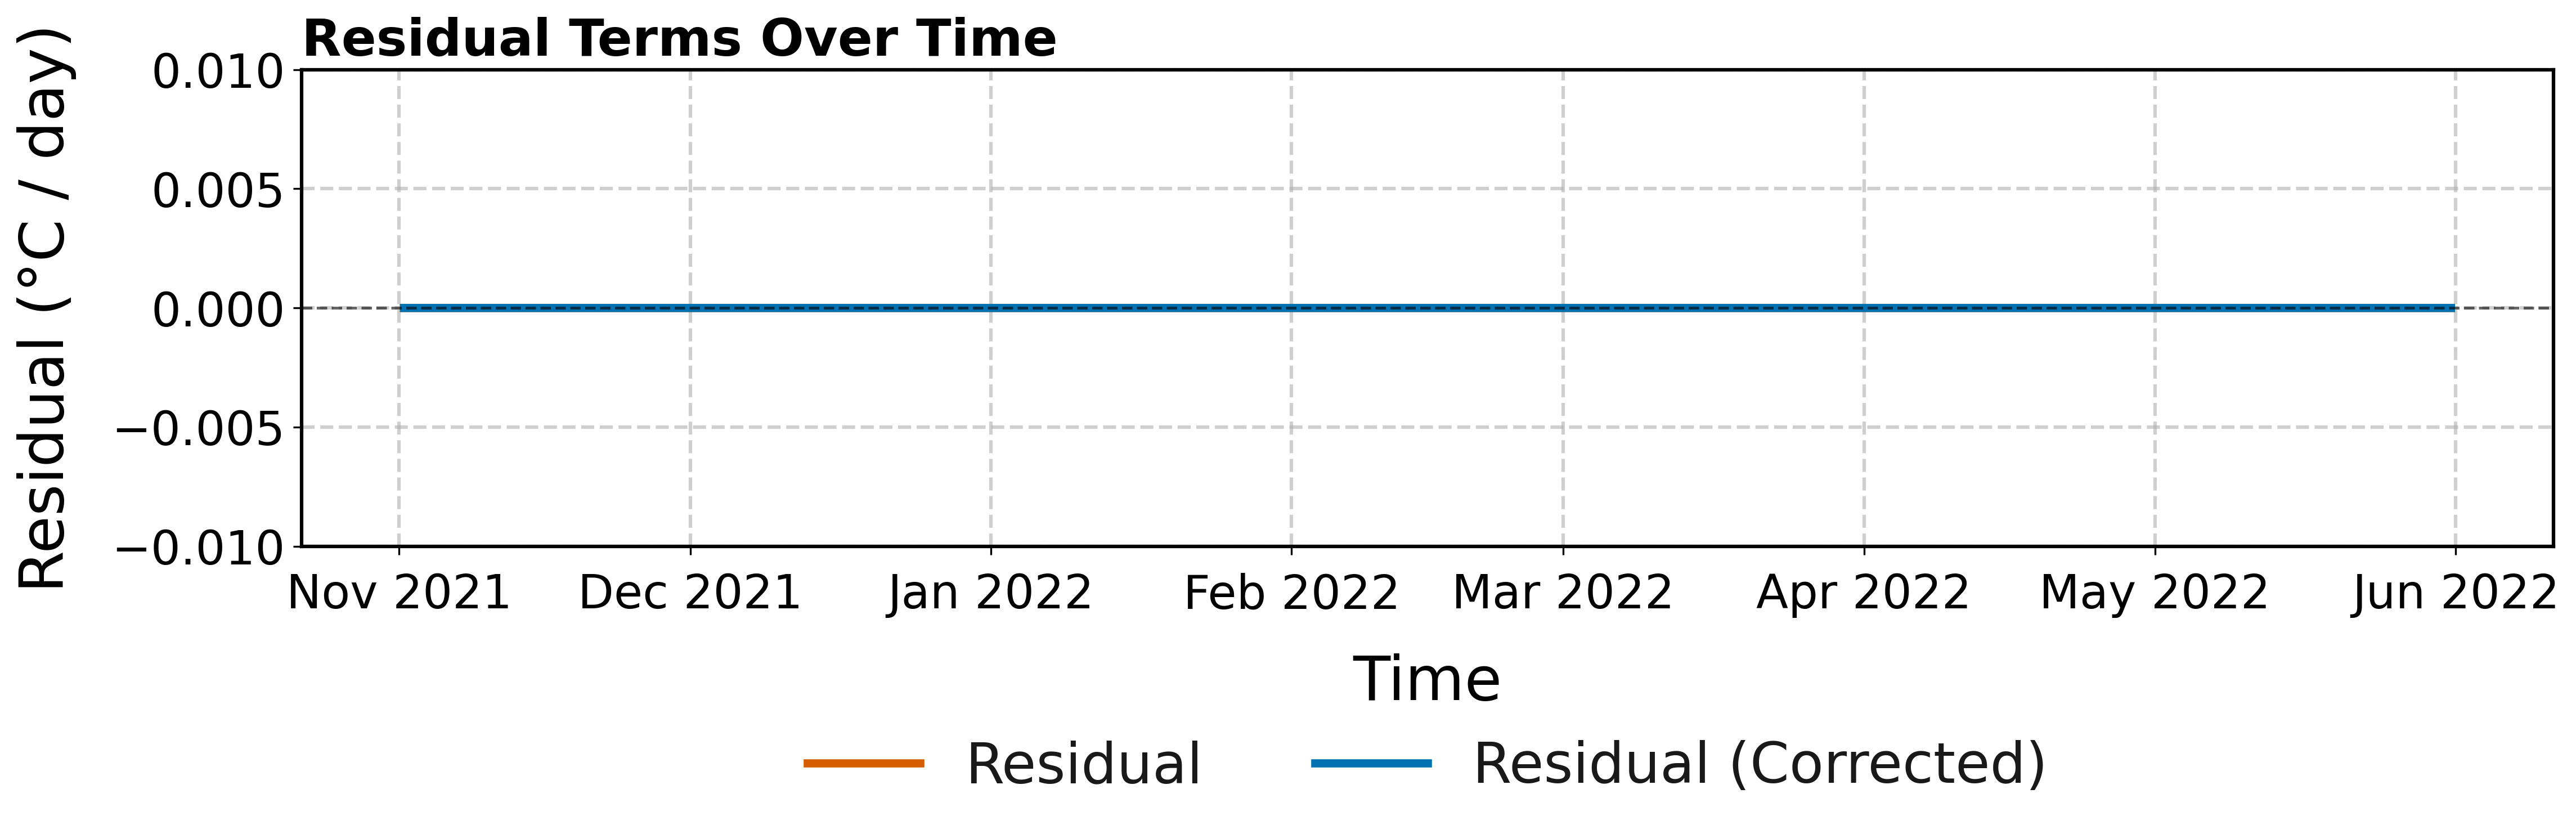

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Select variables
plot_terms = ['Residual', 'Residual_Corrected']

term_labels = {
    "Residual": "Residual",
    "Residual_Corrected": "Residual (Corrected)"
}

# Prepare data
ds_resid = ds_reynolds[plot_terms].sel(time=slice('2021-11-01', '2022-05-31'))
df_resid = ds_resid.to_array(name="value", dim="Variable").to_dataframe().reset_index()
df_resid['Variable'] = df_resid['Variable'].map(term_labels)

# Matplotlib style
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 24,
    'axes.labelsize': 26,
    'axes.titlesize': 28,
    'legend.fontsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 300,
})

# Set up figure
fig, ax = plt.subplots(figsize=(16, 6))

# Colors for lines
color_map_cb = {
    "Residual": "#D55E00",             # Vermillion
    "Residual (Corrected)": "#0072B2"  # Blue
}

# Plot each variable
for var in df_resid['Variable'].unique():
    subset = df_resid[df_resid['Variable'] == var]
    ax.plot(subset['time'], subset['value'], label=var,
            color=color_map_cb.get(var, 'black'), linewidth=3.5)

# --- Add zero reference line ---
ax.axhline(0, color='k', linestyle='--', linewidth=1.2, alpha=0.6)

# Titles and labels
ax.set_title("Residual Terms Over Time", fontsize=22, loc='left', fontweight='bold')
ax.set_xlabel("Time", labelpad=15)
ax.set_ylabel("Residual (°C / day)", labelpad=15)
ax.set_ylim(-0.01, 0.01)  # adjust if needed

# --- X-axis formatting ---
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for label in ax.get_xticklabels():
    label.set_y(-0.02)
    label.set_rotation(0)
    label.set_horizontalalignment('center')

# Grid and border styling
ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.6)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.5)

# Legend below plot
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)
for text in leg.get_texts():
    text.set_alpha(0.9)
    text.set_color('black')

plt.tight_layout()
plt.show()



## Compare offline Reynolds decomp to online calculation

In [30]:
ds_anom = ds_reynolds['Qprime_1ovrHbar'] + ds_reynolds['Qbar_1ovrHprime'] + ds_reynolds['Qprime_1ovrHprime']
anom_sample_for_diff = anom_sample['Surface Fluxes Grouped']*3600*24
diff = ds_anom - anom_sample_for_diff

=== Overall Time Series Statistics ===
RMSE: 0.0208
Normalized RMSE (RMSE / std): 0.3761
Correlation (r): 0.9406


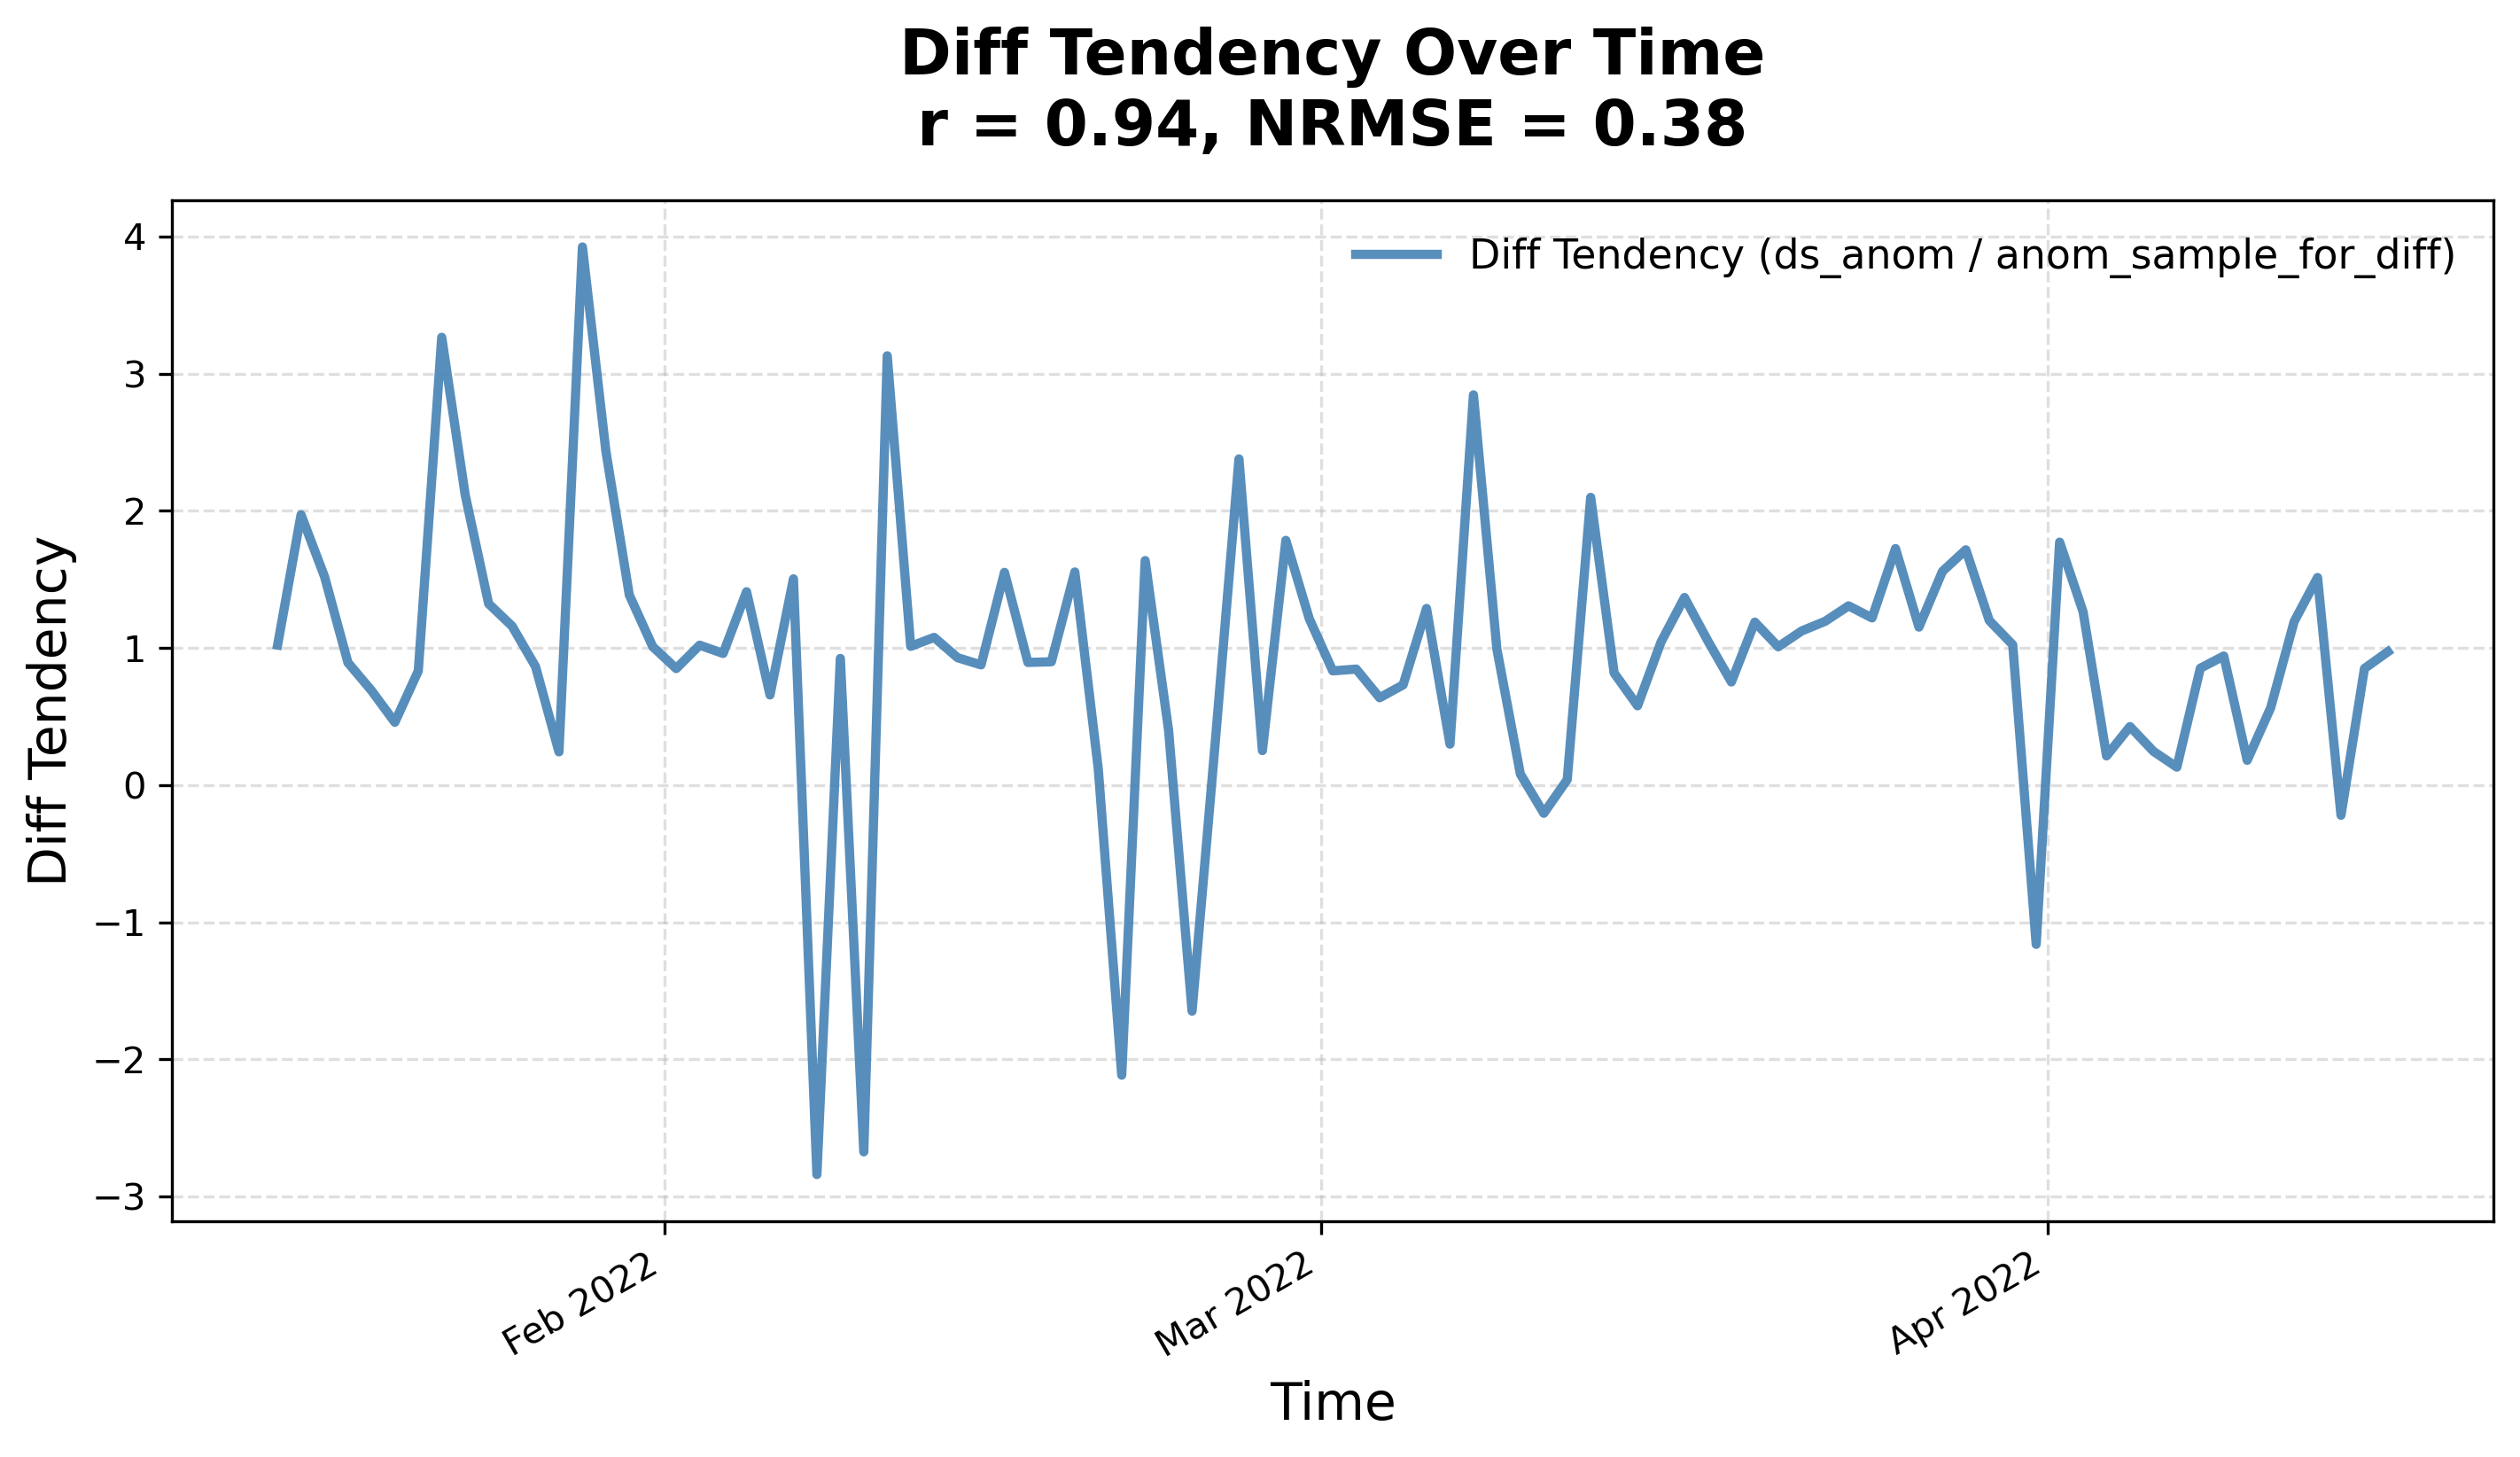

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.dates as mdates

def rmse(a, b=0, dim=None):
    """
    Compute Root Mean Square Error (RMSE) between two xarray objects or DataArrays.
    If b is scalar, computes RMSE of a relative to that scalar.
    """
    if not isinstance(a, xr.DataArray):
        a = xr.DataArray(a)
    if not isinstance(b, xr.DataArray):
        b = xr.DataArray(b)
    return np.sqrt(((a - b) ** 2).mean(dim))

# --- Define anomaly datasets ---
ds_anom = (
    ds_reynolds['Qprime_1ovrHbar'] +
    ds_reynolds['Qbar_1ovrHprime'] +
    ds_reynolds['Qprime_1ovrHprime']
)

# Convert daily surface flux anomaly sample (J/m² per day)
anom_sample_for_diff = anom_sample['Surface Fluxes Grouped'] * 3600 * 24

# Align time axes just in case
ds_anom, anom_sample_for_diff = xr.align(ds_anom, anom_sample_for_diff)

# --- Compute RMSE and Normalized RMSE (NRMSE) ---
root = rmse(ds_anom, anom_sample_for_diff)
std_ref = ds_anom.std()
nrmse = root / std_ref

# --- Compute Pearson Correlation between the two time series ---
# Flatten if they are multi-dimensional (e.g., time, lat, lon)
a_flat = ds_anom.stack(z=('time',)) if 'time' in ds_anom.dims else ds_anom
b_flat = anom_sample_for_diff.stack(z=('time',)) if 'time' in anom_sample_for_diff.dims else anom_sample_for_diff

corr = np.corrcoef(a_flat.values.ravel(), b_flat.values.ravel())[0, 1]

print("=== Overall Time Series Statistics ===")
print(f"RMSE: {float(root.compute()):.4f}")
print(f"Normalized RMSE (RMSE / std): {float(nrmse.compute()):.4f}")
print(f"Correlation (r): {corr:.4f}")

# --- Diagnostic diff tendency ---
diff_tendency = ds_anom / anom_sample_for_diff
diff_tendency_plot = diff_tendency.sel(time=slice('2022-01-15', '2022-05-01'))

# --- Plot ---
plt.figure(figsize=(10, 6))

plt.plot(
    diff_tendency_plot['time'], diff_tendency_plot,
    color='steelblue',
    linewidth=2.5,
    alpha=0.9,
    label='Diff Tendency (ds_anom / anom_sample_for_diff)'
)

plt.title(
    f"Diff Tendency Over Time\n"
    f"r = {corr:.2f}, NRMSE = {float(nrmse.compute()):.2f}",
    fontsize=17, fontweight='bold', pad=15
)

plt.xlabel("Time", fontsize=14)
plt.ylabel("Diff Tendency", fontsize=14)

plt.tick_params(axis='both', labelsize=10)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=30, ha='right')

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.show()


Overall RMSE: <xarray.DataArray ()> Size: 8B
array(0.02084468)
RMSE over time: <xarray.DataArray ()> Size: 8B
array(1.59304787)


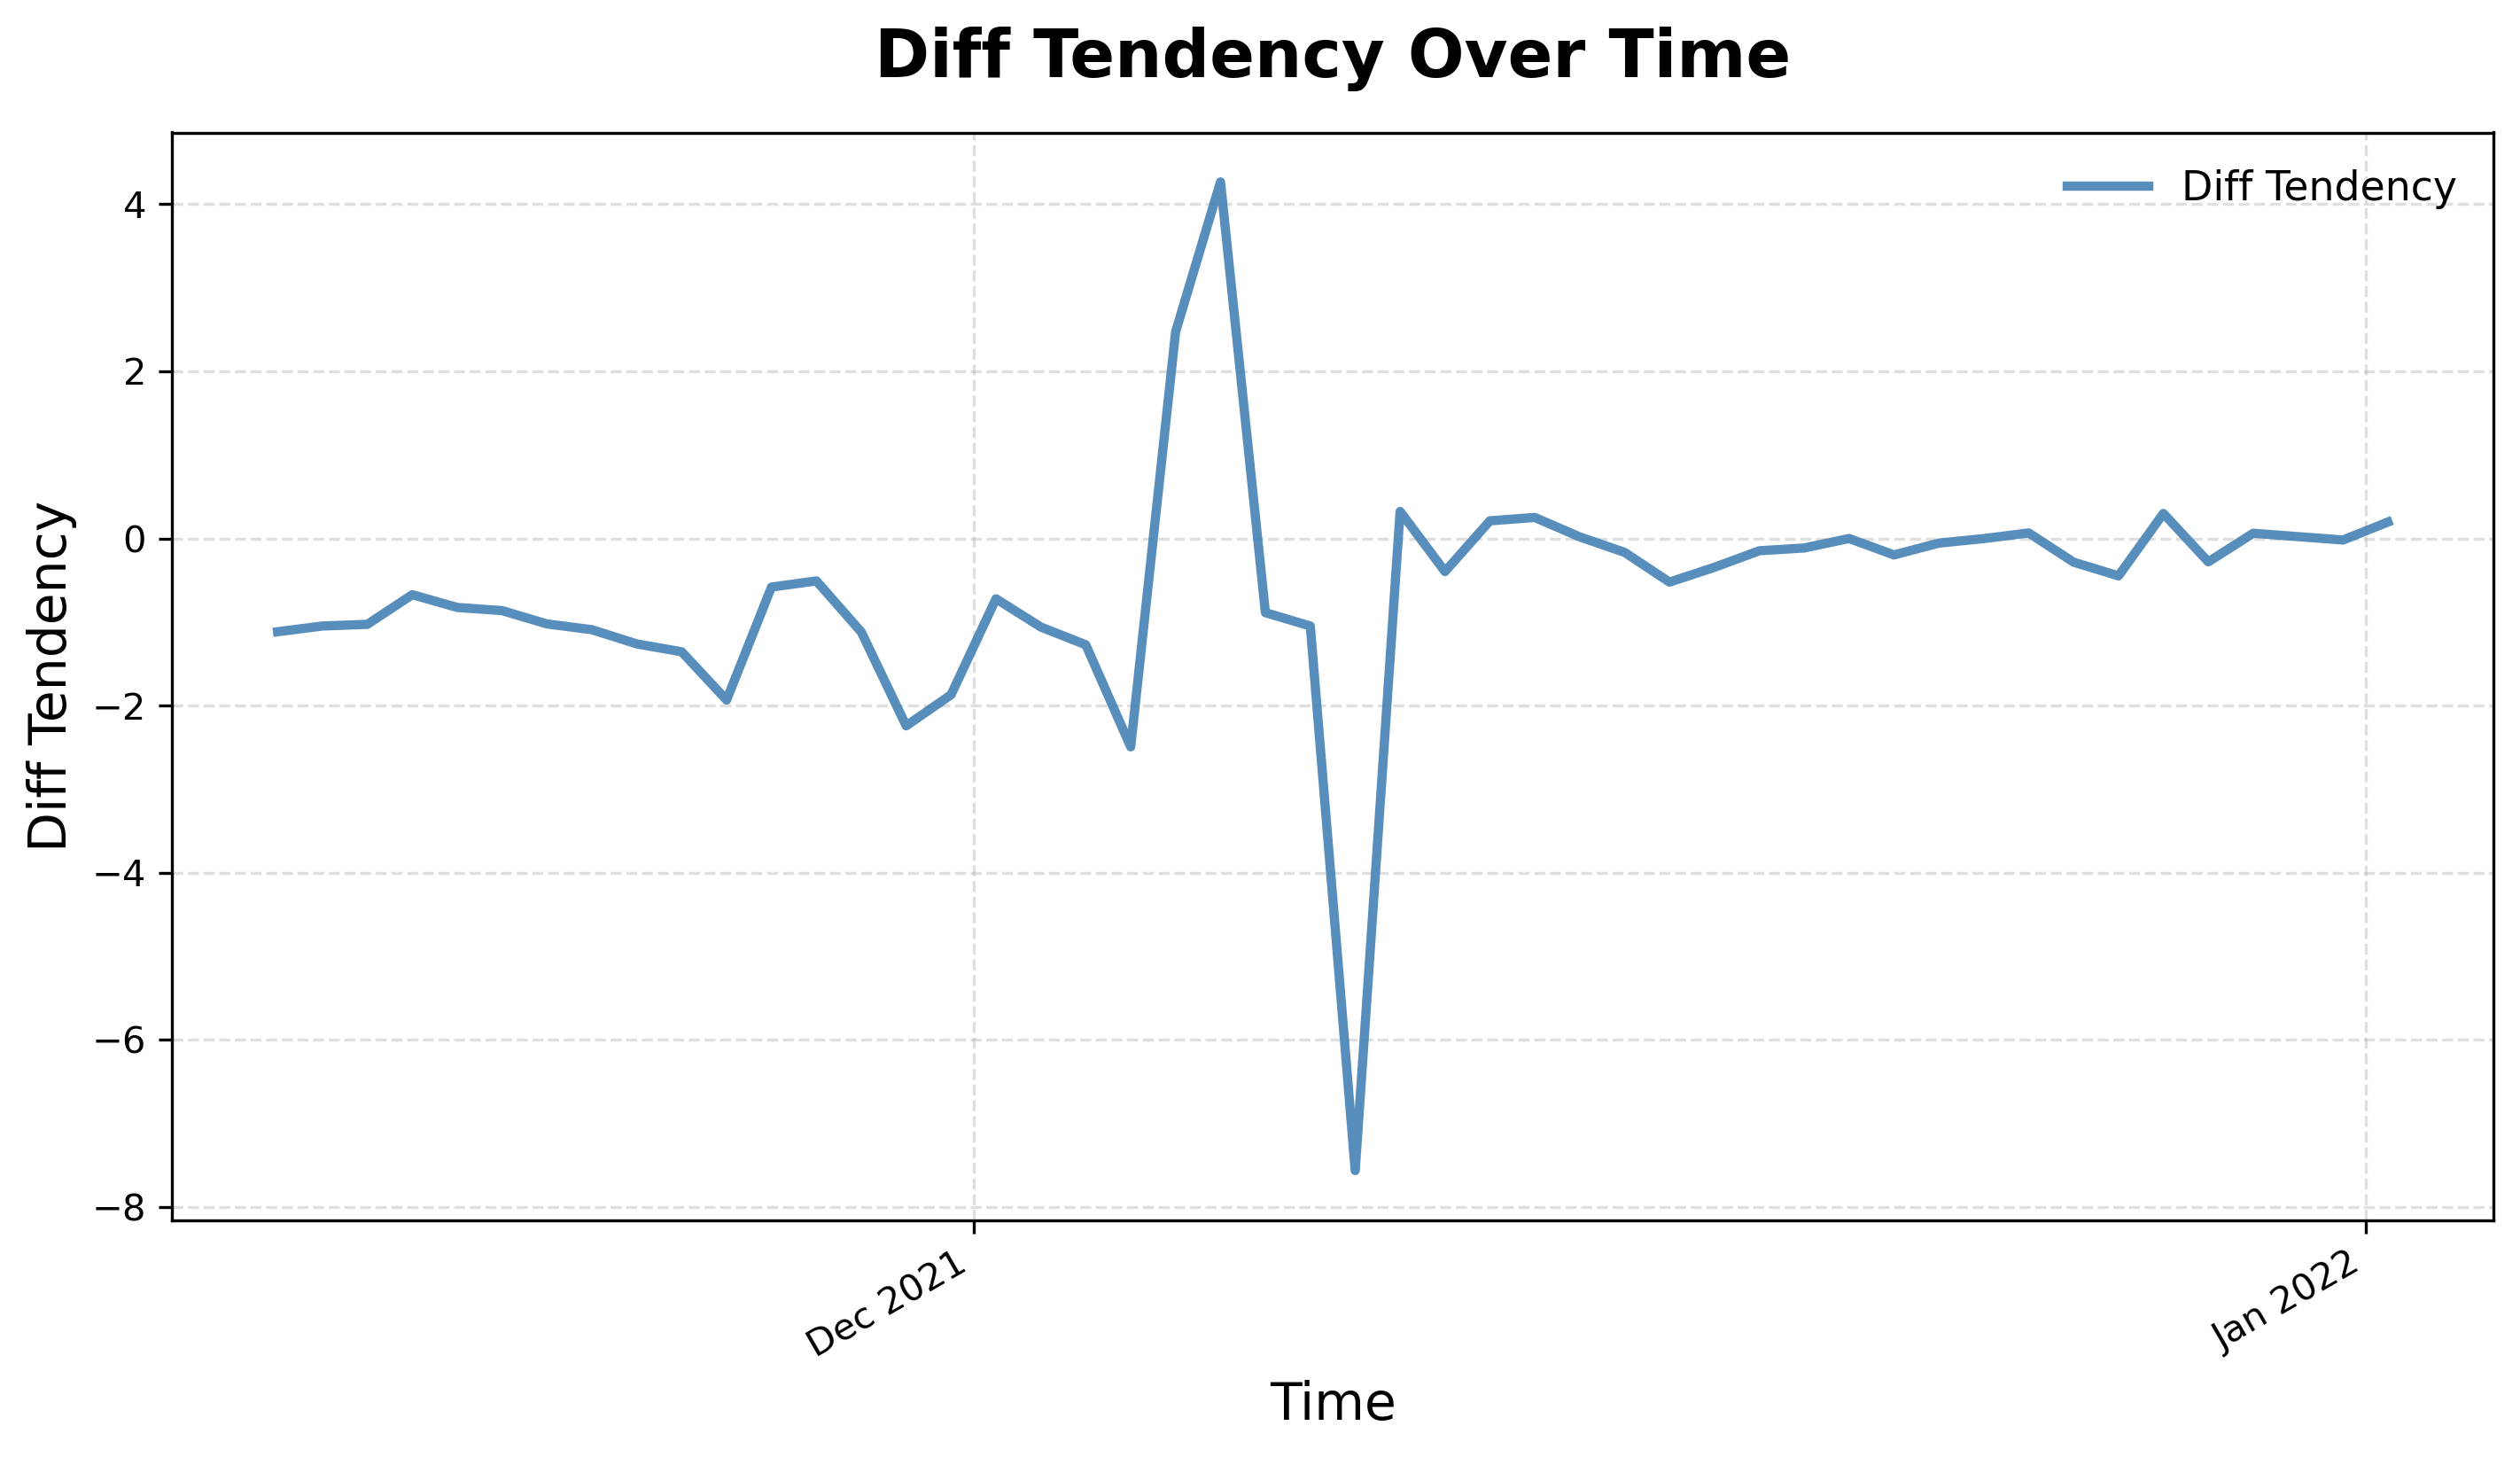

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.dates as mdates

def rmse(a, b=0, dim=None):
    """
    Compute Root Mean Square Error (RMSE) between two xarray objects or DataArrays.
    If b is scalar, computes RMSE of a relative to that scalar.
    """
    if not isinstance(a, xr.DataArray):
        a = xr.DataArray(a)
    if not isinstance(b, xr.DataArray):
        b = xr.DataArray(b)
    return np.sqrt(((a - b) ** 2).mean(dim))

diff_tendency = diff / anom_sample_for_diff

root = rmse(ds_anom, anom_sample_for_diff)
print("Overall RMSE:", root.compute())

diff_tendency_plot = diff_tendency.sel(time=slice('2021-11-15', '2022-01-01'))
rmse_time = rmse(diff_tendency_plot, 0, dim='time')
print("RMSE over time:", rmse_time.compute())

plt.figure(figsize=(10, 6))

plt.plot(
    diff_tendency_plot['time'], diff_tendency_plot,
    color='steelblue',
    linewidth=2.5,
    alpha=0.9,
    label='Diff Tendency'
)

plt.title("Diff Tendency Over Time", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Diff Tendency", fontsize=14)

plt.tick_params(axis='both', labelsize=10)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=30, ha='right')

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.show()


# Plot the MLD and salinity!

## Load in salinity (mld already loaded above)

In [33]:
variable = 'salt_in_mld'

sss_sample = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='salt_in_mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}).\
                          sel(xt_ocean = xt_coord, yt_ocean = yt_coord).sel(time = time)

sss_sample = sss_sample.mean(['xt_ocean', 'yt_ocean'])
sss_sample = sss_sample/1035 ## Need to divide by 1035 as the data is multiplied by this during execution
sss_sample.load()

<xarray.DataArray 'salt_in_mld' (time: 212)> Size: 848B
array([34.40435 , 34.404427, 34.40482 , 34.40527 , 34.405457, 34.406067,
       34.40468 , 34.403263, 34.402256, 34.4008  , 34.399105, 34.397995,
       34.39689 , 34.39648 , 34.39443 , 34.39156 , 34.38938 , 34.38904 ,
       34.388237, 34.3817  , 34.375072, 34.36674 , 34.35874 , 34.35234 ,
       34.344074, 34.320896, 34.287407, 34.2869  , 34.268906, 34.24669 ,
       34.229496, 34.21701 , 34.203182, 34.184746, 34.16578 , 34.15691 ,
       34.144176, 34.131912, 34.1242  , 34.111027, 34.094963, 34.082607,
       34.065422, 34.0377  , 34.005783, 33.978825, 33.968464, 33.954773,
       33.938835, 33.91158 , 33.89356 , 33.8827  , 33.87113 , 33.854095,
       33.83789 , 33.843166, 33.84305 , 33.840496, 33.82826 , 33.815964,
       33.795376, 33.773003, 33.74811 , 33.718803, 33.69697 , 33.684345,
       33.70964 , 33.73438 , 33.734653, 33.730854, 33.72127 , 33.711945,
       33.794914, 33.899376, 33.906036, 33.899483, 33.8939  , 33.887794,
       33.87913 , 33.86662 , 33.862743, 33.862267, 33.86281 , 33.857826,
       33.851795, 33.84345 , 33.83333 , 33.829243, 33.83202 , 33.828564,
       33.82334 , 33.81677 , 33.810066, 33.805634, 33.802094, 33.80065 ,
       33.798466, 33.80273 , 33.80576 , 33.80362 , 33.80581 , 33.807953,
       33.805923, 33.803646, 33.800304, 33.79561 , 33.789192, 33.783627,
       33.77679 , 33.77935 , 33.78068 , 33.782166, 33.78229 , 33.786343,
       33.78336 , 33.788982, 33.78841 , 33.79032 , 33.788662, 33.789314,
       33.7939  , 33.79592 , 33.797916, 33.799145, 33.803448, 33.815117,
       33.816536, 33.815495, 33.81672 , 33.82093 , 33.815945, 33.82523 ,
       33.83079 , 33.830902, 33.83114 , 33.833485, 33.836708, 33.841335,
       33.845474, 33.85083 , 33.858406, 33.8674  , 33.87979 , 33.89885 ,
       33.9248  , 33.954224, 33.975365, 33.991142, 34.004066, 34.01166 ,
       34.017868, 34.0293  , 34.04168 , 34.044334, 34.043957, 34.044895,
       34.045727, 34.046562, 34.049294, 34.0544  , 34.05846 , 34.063175,
       34.06583 , 34.067814, 34.07162 , 34.077038, 34.08436 , 34.09046 ,
       34.094955, 34.10055 , 34.106586, 34.11141 , 34.11813 , 34.125504,
       34.12744 , 34.13013 , 34.133354, 34.13492 , 34.136444, 34.13956 ,
       34.146046, 34.150684, 34.151573, 34.15257 , 34.15388 , 34.155884,
       34.158104, 34.159466, 34.160416, 34.1609  , 34.16168 , 34.16282 ,
       34.163914, 34.166416, 34.168217, 34.16833 , 34.168682, 34.170124,
       34.171566, 34.173027, 34.1744  , 34.176586, 34.18089 , 34.182884,
       34.18366 , 34.18343 , 34.182545, 34.18188 , 34.18162 , 34.18206 ,
       34.182087, 34.182415], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2021-11-01T12:00:00 ... 2022-05-31T12:...

In [34]:
sss_sample = sss_sample.sel(time = time_coord)

In [35]:
sss_clim_sample = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='salt_in_mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}).\
                          sel(time = clim_time).\
                          sel(xt_ocean = xt_coord, yt_ocean = yt_coord)

sss_clim_sample = sss_clim_sample/1035
sss_clim_sample = sss_clim_sample.mean(['xt_ocean', 'yt_ocean'])
sss_clim_sample.load()

<xarray.DataArray 'salt_in_mld' (time: 10957)> Size: 44kB
array([33.717857, 33.69584 , 33.66336 , ..., 33.46871 , 33.434334,
       33.39862 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88kB 1982-01-01T12:00:00 ... 2011-12-31T12...

In [36]:
sss_clim = smoothedClima_mhw(sss_clim_sample) 

In [37]:
sss_clim_daily = sss_clim.sel(dayofyear=sss_sample['time'].dt.dayofyear)
sss_clim_daily = sss_clim_daily.assign_coords(time=sss_sample['time'])
sss_clim_daily

<xarray.DataArray 'salt_in_mld' (time: 212)> Size: 848B
array([34.205   , 34.2046  , 34.204082, 34.20351 , 34.202866, 34.20209 ,
       34.201256, 34.20036 , 34.199306, 34.19799 , 34.196377, 34.194496,
       34.192375, 34.189938, 34.187325, 34.18455 , 34.18152 , 34.178055,
       34.174107, 34.169575, 34.164413, 34.15863 , 34.15209 , 34.144714,
       34.13645 , 34.127346, 34.11762 , 34.107388, 34.09673 , 34.085308,
       34.07314 , 34.06027 , 34.046803, 34.0325  , 34.017223, 34.001144,
       33.984787, 33.967896, 33.95026 , 33.93225 , 33.914135, 33.895584,
       33.876537, 33.856834, 33.836494, 33.81576 , 33.793716, 33.773476,
       33.7531  , 33.732418, 33.711536, 33.69021 , 33.66833 , 33.64613 ,
       33.623825, 33.601727, 33.579945, 33.558147, 33.53631 , 33.514404,
       33.492706, 33.450584, 33.430157, 33.410187, 33.390797, 33.371822,
       33.35282 , 33.334175, 33.3162  , 33.298573, 33.281178, 33.26441 ,
       33.24827 , 33.233025, 33.21859 , 33.20471 , 33.192223, 33.17813 ,
       33.1645  , 33.15165 , 33.139637, 33.128742, 33.119026, 33.11044 ,
       33.102787, 33.09587 , 33.089558, 33.08414 , 33.079853, 33.076374,
       33.07371 , 33.07188 , 33.070503, 33.069744, 33.069946, 33.07103 ,
       33.072937, 33.075684, 33.07916 , 33.08323 , 33.08798 , 33.09342 ,
       33.099545, 33.106407, 33.113823, 33.12196 , 33.13075 , 33.140335,
       33.1507  , 33.161816, 33.173542, 33.185875, 33.19895 , 33.212627,
       33.226868, 33.241695, 33.257084, 33.27306 , 33.289394, 33.30582 ,
       33.322628, 33.339844, 33.357258, 33.374844, 33.39249 , 33.410057,
       33.4276  , 33.445183, 33.46276 , 33.48021 , 33.49759 , 33.514877,
       33.53198 , 33.54885 , 33.565517, 33.581997, 33.59821 , 33.61407 ,
       33.62951 , 33.64452 , 33.65914 , 33.673466, 33.68739 , 33.70077 ,
       33.713787, 33.72642 , 33.738686, 33.750534, 33.761936, 33.77294 ,
       33.783524, 33.793682, 33.803402, 33.812798, 33.821896, 33.830765,
       33.839397, 33.847782, 33.855934, 33.86383 , 33.8715  , 33.87892 ,
       33.88607 , 33.89299 , 33.89967 , 33.90608 , 33.912247, 33.918213,
       33.923985, 33.929573, 33.93499 , 33.940247, 33.94531 , 33.95019 ,
       33.954903, 33.959465, 33.963867, 33.968124, 33.972282, 33.976345,
       33.980305, 33.984184, 33.987953, 33.991615, 33.995182, 33.99868 ,
       34.00211 , 34.00544 , 34.00869 , 34.011814, 34.014828, 34.017757,
       34.020596, 34.02335 , 34.026035, 34.02865 , 34.031204, 34.033726,
       34.036182, 34.038593, 34.040943, 34.043217, 34.04543 , 34.04761 ,
       34.049763, 34.05189 , 34.053974, 34.05602 , 34.058033, 34.06001 ,
       34.061947, 34.06386 ], dtype=float32)
Coordinates:
    dayofyear  (time) int64 2kB 305 306 307 308 309 310 ... 147 148 149 150 151
  * time       (time) datetime64[ns] 2kB 2021-11-01T12:00:00 ... 2022-05-31T1...

In [38]:
sss_anom = (sss_sample - sss_clim_daily)
sss_anom.load()

<xarray.DataArray 'salt_in_mld' (time: 212)> Size: 848B
array([0.19934845, 0.19982529, 0.200737  , 0.20175934, 0.20259094,
       0.20397568, 0.20342255, 0.20290375, 0.20294952, 0.20280838,
       0.20272827, 0.20349884, 0.20451355, 0.20654297, 0.20710373,
       0.20700836, 0.20786285, 0.21098709, 0.2141304 , 0.21212387,
       0.21065903, 0.20811081, 0.2066536 , 0.20762634, 0.20762253,
       0.19355011, 0.16978836, 0.17951202, 0.17217636, 0.16138077,
       0.15635681, 0.1567421 , 0.1563797 , 0.15224457, 0.14855576,
       0.15576553, 0.1593895 , 0.16401672, 0.17393875, 0.17877579,
       0.1808281 , 0.18702316, 0.18888474, 0.18086624, 0.16928864,
       0.16306305, 0.17474747, 0.1812973 , 0.1857338 , 0.17916107,
       0.1820221 , 0.19249344, 0.20280075, 0.20796585, 0.21406555,
       0.24143982, 0.2631035 , 0.28234863, 0.29195023, 0.30155945,
       0.30266953, 0.3224182 , 0.31795502, 0.30861664, 0.30617523,
       0.3125229 , 0.35681915, 0.4002037 , 0.41845322, 0.4322815 ,
       0.440094  , 0.44753647, 0.5466461 , 0.6663513 , 0.6874466 ,
       0.6947746 , 0.7016792 , 0.7096634 , 0.7146301 , 0.71496964,
       0.7231064 , 0.7335243 , 0.74378204, 0.74738693, 0.7490082 ,
       0.74757767, 0.7437706 , 0.7451019 , 0.75216675, 0.75218964,
       0.74963   , 0.7448883 , 0.739563  , 0.73588943, 0.7321472 ,
       0.7296219 , 0.7255287 , 0.72704697, 0.72660065, 0.7203903 ,
...
       0.547287  , 0.5313263 , 0.5172615 , 0.49926758, 0.4834938 ,
       0.4712715 , 0.45607758, 0.44065857, 0.42430115, 0.41095734,
       0.4050598 , 0.3889351 , 0.37031174, 0.35395813, 0.34072113,
       0.31835556, 0.31035233, 0.29881287, 0.2820511 , 0.2656212 ,
       0.25148773, 0.23849869, 0.2272644 , 0.21596527, 0.20631027,
       0.19926453, 0.1939354 , 0.19240189, 0.19807816, 0.2110138 ,
       0.22780228, 0.23667908, 0.24060822, 0.24213028, 0.23871994,
       0.23434448, 0.23561859, 0.23827744, 0.23153687, 0.22206116,
       0.2141304 , 0.20632935, 0.19878006, 0.19335938, 0.19057083,
       0.18696213, 0.1842537 , 0.17975998, 0.17482376, 0.1719513 ,
       0.17095947, 0.17211151, 0.17224884, 0.17097092, 0.17097855,
       0.17159653, 0.17116165, 0.17282104, 0.17531204, 0.17253876,
       0.17066574, 0.169487  , 0.16679382, 0.16416168, 0.16321564,
       0.16574097, 0.16650009, 0.16362   , 0.16095352, 0.15869904,
       0.15720367, 0.15599442, 0.15402603, 0.15172577, 0.149086  ,
       0.14685059, 0.1450615 , 0.14331818, 0.1430664 , 0.1421814 ,
       0.13968277, 0.13747787, 0.13639832, 0.1353836 , 0.13443375,
       0.13345718, 0.13336945, 0.1354599 , 0.13527298, 0.13389587,
       0.13153839, 0.12857056, 0.12586212, 0.12358856, 0.12205124,
       0.12014008, 0.11855316], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2021-11-01T12:00:00 ... 2022-05-31T1...
    dayofyear  (time) int64 2kB 305 306 307 308 309 310 ... 147 148 149 150 151

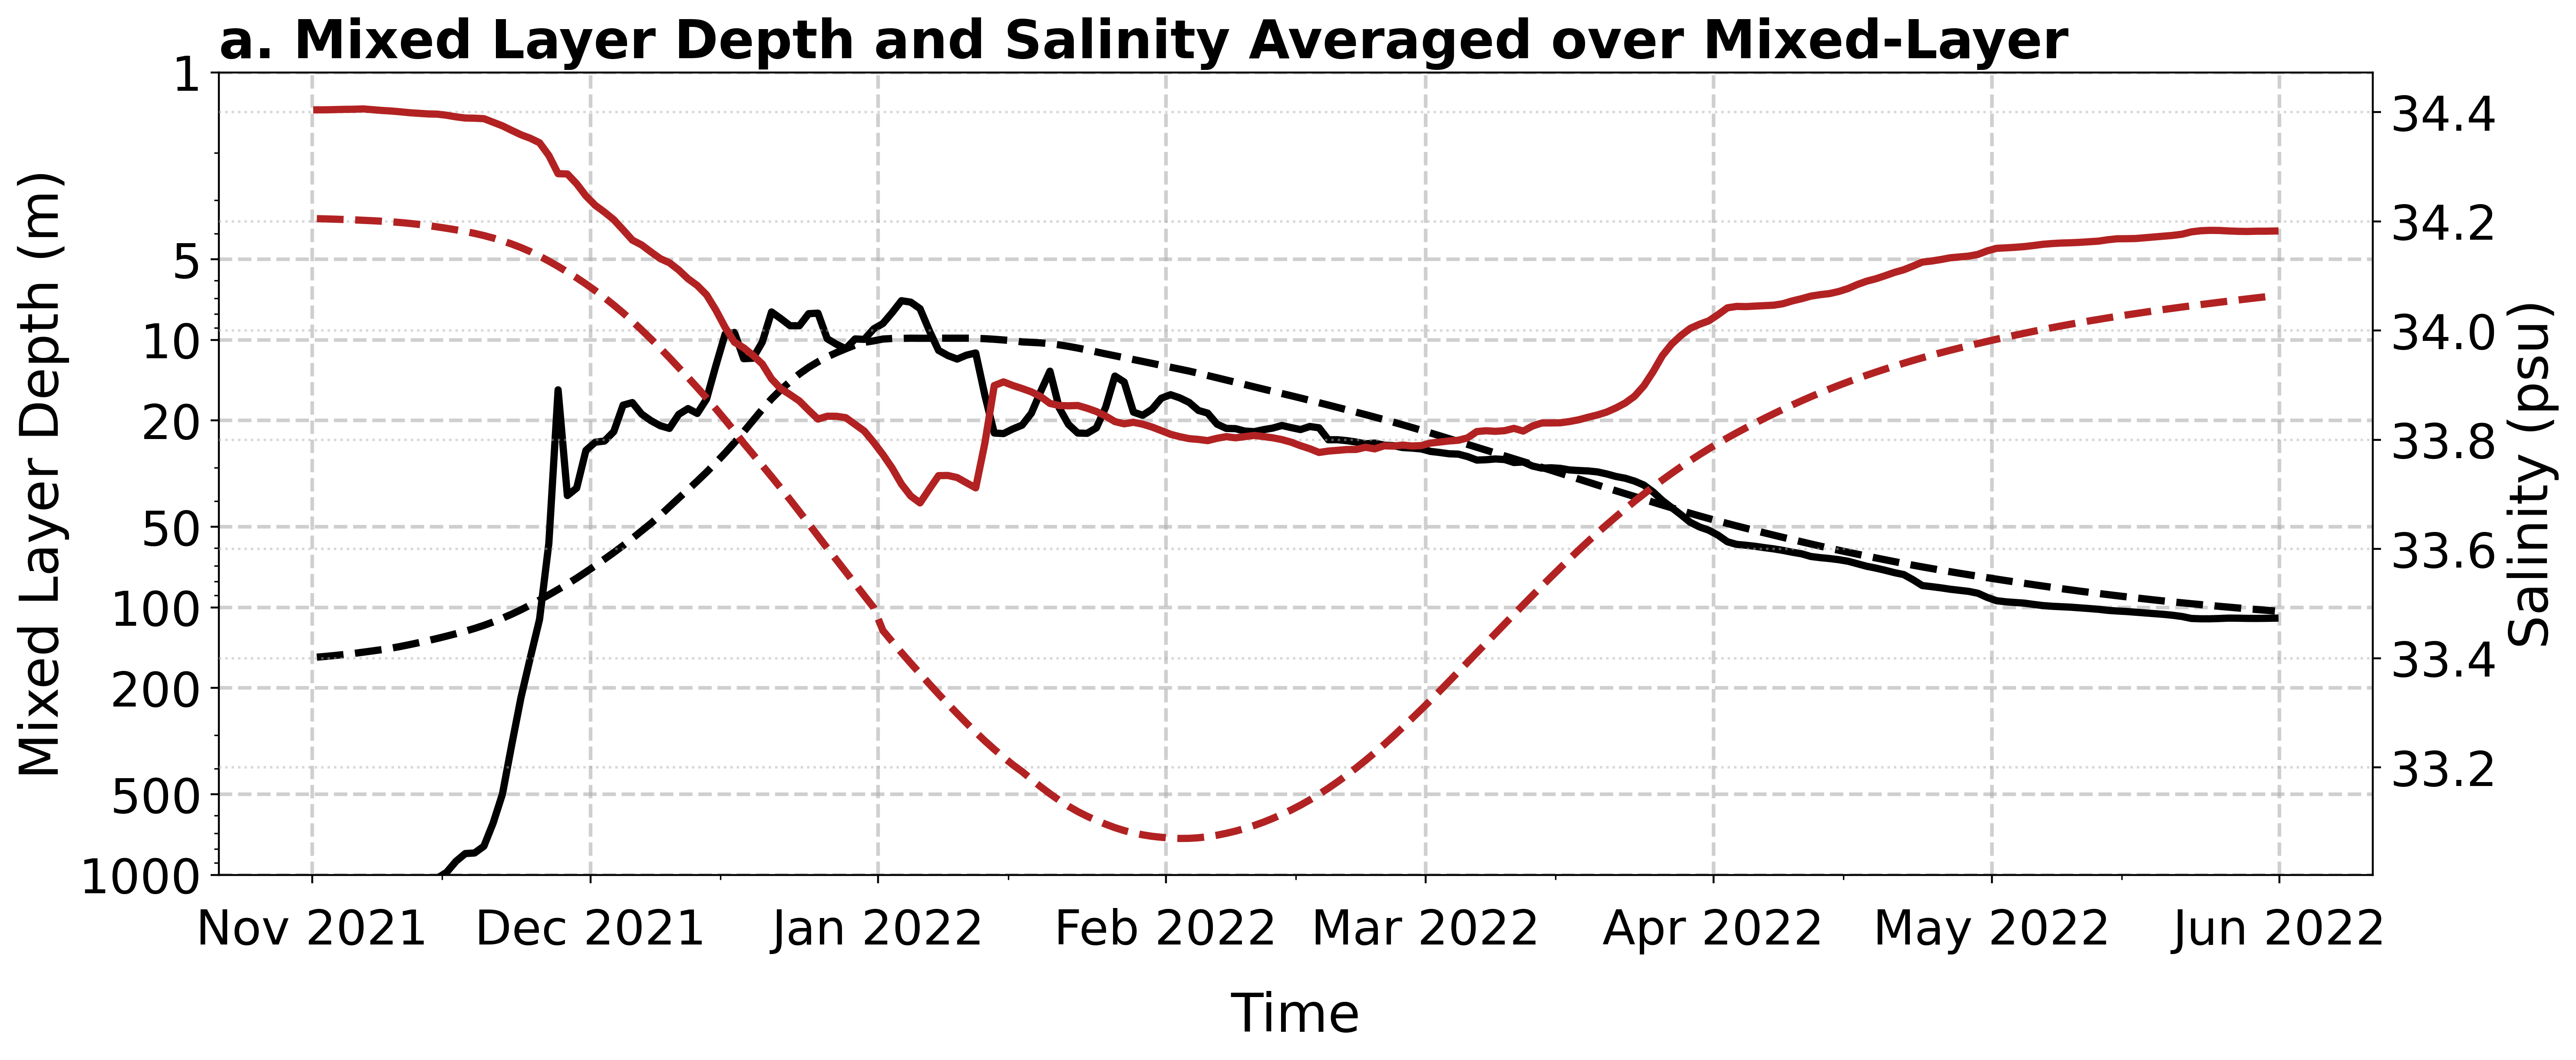

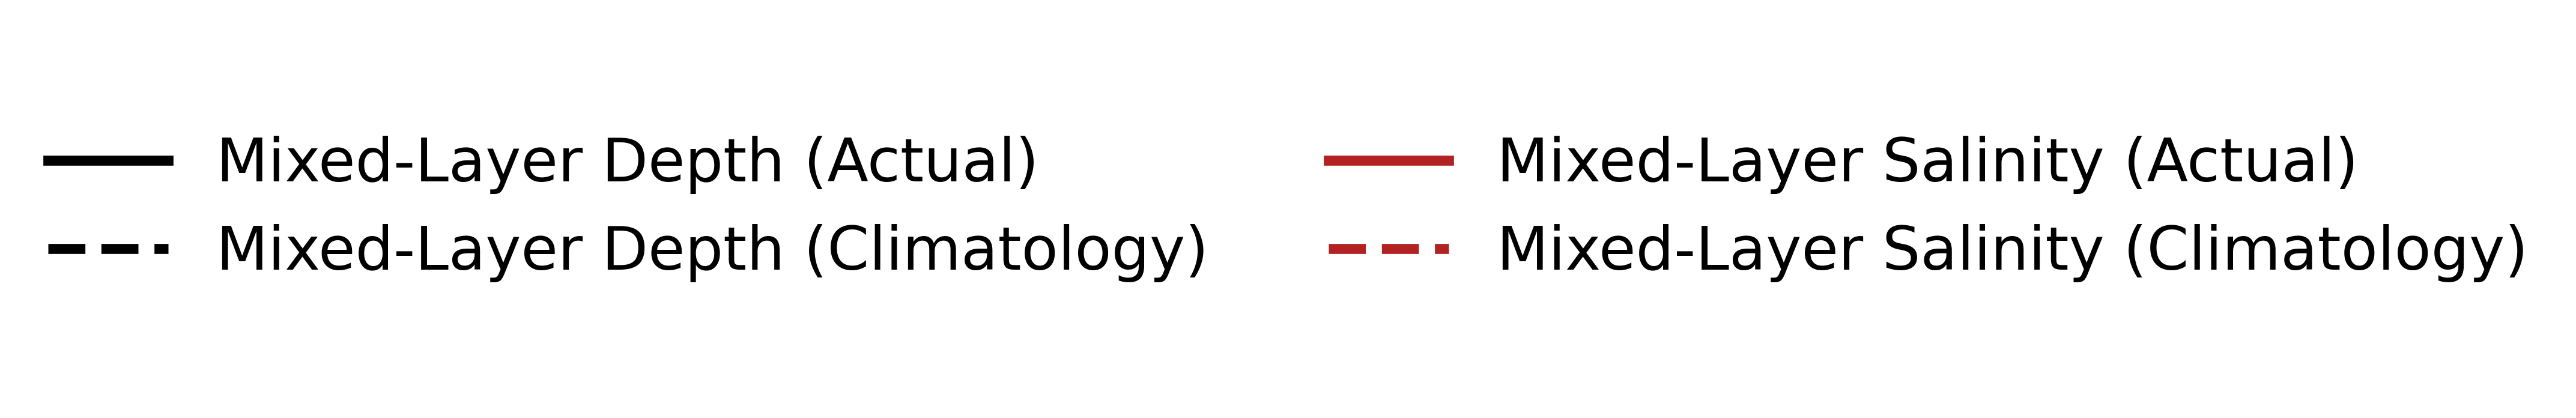

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# --- Global style for consistency ---
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # Closest to Arial I was able to find, trying to keep it consistent for when I use InkScape
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'legend.fontsize': 18,
    'figure.dpi': 300,
})


# --- Daily MLD + SSS anomaly plot ---
fig, ax1 = plt.subplots(figsize=(16, 6), dpi=400)
ax2 = ax1.twinx()

# Select time range
mld_sample_sample = mld_sample.sel(time=slice('2021-11-01', '2022-05-31'))
mld_clim_daily_sample = mld_clim_daily.sel(time=slice('2021-11-01', '2022-05-31'))

# Plot daily MLD data
ax1.plot(mld_sample_sample['time'], mld_sample_sample,
         label='Mixed-Layer Depth (Actual)', color='black', linewidth=3)
ax1.plot(mld_clim_daily_sample['time'], mld_clim_daily_sample,
         label='Mixed-Layer Depth (Climatology)', color='black', linewidth=3, linestyle='--')

# --- Logarithmic and inverted Y axis for MLD ---
ax1.set_yscale('log')
ax1.invert_yaxis()
ax1.set_ylim(1000, 1)
ax1.set_ylabel('Mixed Layer Depth (m)')

# Custom tick locations for log scale
mld_ticks = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
ax1.set_yticks(mld_ticks)
ax1.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax1.get_yaxis().set_minor_formatter(ticker.NullFormatter())

# --- X axis: month-year labels ---
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=(1, 15)))

# Adjust tick labels
for label in ax1.get_xticklabels():
    label.set_y(-0.02)
    label.set_fontsize(20)

ax1.set_xlabel('Time', labelpad=15)
ax2.set_title("a. Mixed Layer Depth and Salinity Averaged over Mixed-Layer",
              loc='left', fontweight='bold', fontsize=22)

# Style spines
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(.8)
    
ax1.grid(True, linestyle='--', linewidth=1.5, alpha=0.6)
ax1.tick_params(axis='y', colors='black', labelsize = 20)

# Prepare SSS data
sss_clim_daily_plot = sss_clim_daily.sel(time=slice('2021-11-01', '2022-05-31'))
sss_sample_plot = sss_sample.sel(time=slice('2021-11-01', '2022-05-31'))

# --- Right axis (SSS) ---
ax2.plot(sss_sample_plot['time'], sss_sample_plot,
         color='firebrick', linewidth=3, label='Mixed-Layer Salinity (Actual)')

ax2.plot(sss_clim_daily_plot['time'], sss_clim_daily_plot,
         color='firebrick', linewidth=3, label='Mixed-Layer Salinity (Climatology)', linestyle='--')

ax2.set_ylabel('Salinity (psu)', color='black')
ax2.tick_params(axis='y', colors='black', labelsize = 20)

for spine in ax2.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1.0)  
    spine.set_alpha(0.)      

ax2.grid(True, axis='y', linestyle=':', linewidth=1, alpha=0.5)
ax2.patch.set_alpha(0)

# --- Collect legend handles/labels ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
all_lines = lines1 + lines2
all_labels = labels1 + labels2

plt.show()  

fig_legend = plt.figure(figsize=(10, 2),dpi=400)
ax_leg = fig_legend.add_subplot(111)   # dummy axes
ax_leg.axis("off")                     # hide the axes
ax_leg.legend(all_lines, all_labels, loc='center', ncol=2, frameon=False)

fig.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Melt_Shoaling.png", dpi=400, bbox_inches="tight")
fig_leg.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Melt_Shoaling_Legend.png", dpi=400, bbox_inches="tight")

plt.show()


# Cooling from Sea-Ice Melt

In [40]:
yt_coord = slice(-80,-65)
xt_coord = slice(-205,-120)
time_coord = slice('2021-11-01','2022-05-31')

In [41]:
import xarray as xr

file_list = [
    f'/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/JRA_SST_Processed/Heat_Budget_Data/full_mixed_layer_heat_budget_output{idx}.nc'
    for idx in range(330, 372)  
]

ds = xr.open_mfdataset(file_list, combine='by_coords')
ds

<xarray.Dataset> Size: 708GB
Dimensions:                 (xt_ocean: 1440, yt_ocean: 196, time: 15298)
Coordinates:
  * xt_ocean                (xt_ocean) float64 12kB -279.9 -279.6 ... 79.88
  * yt_ocean                (yt_ocean) float64 2kB -81.08 -80.97 ... -60.08
  * time                    (time) datetime64[ns] 122kB 1982-01-02 ... 2023-1...
Data variables: (12/21)
    fixedh_tendency         (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    temp_adv                (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    submeso                 (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    neut_diffusion          (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    neutral_gm              (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    temp_vdiffuse_k33       (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    ...                      ...
    sens_heat               (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    evap_heat               (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    sw_heat_in_mld          (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    residual                (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    mlt_tendency            (time, yt_ocean, xt_ocean) float32 17GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
    entrainment             (time, yt_ocean, xt_ocean) float64 35GB dask.array<chunksize=(364, 196, 1440), meta=np.ndarray>
Attributes:
    Project:   Antarctic Seasonal Ice Zone MHWs 1982-2019 (plus extension to ...
    Author:    Tom Schmaltz - Hons Student 2025
    Data set:  ACCESS-OM2-025 IAF simulation forced by JRA55 (cycle6)
    Created:   2025-10-20
    Mail:      t.schmaltz@student.unsw.edu.au

In [42]:
## Choose specific location and time for analyses
time_plot = time_coord

data_sample = ds.sel(time = time_coord).\
        sel(yt_ocean = yt_coord, xt_ocean = xt_coord)#.\
        #mean(['xt_ocean', 'yt_ocean'])

## Add grouped terms to make analysis easier
data_sample['Grouped Advection'] = data_sample['temp_adv'] + \
                                   data_sample['submeso'] + \
                                   data_sample['neut_diffusion'] + \
                                   data_sample['neutral_gm'] + \
                                   data_sample['temp_vdiffuse_k33']

data_sample['Grouped Vertical Mixing'] = data_sample['temp_nonlocal_KPP'] + \
                                         data_sample['temp_vdiffuse_diff_cbt']

data_sample['Surface Fluxes Grouped'] = data_sample['temp_rivermix'] + \
                              data_sample['temp_vdiffuse_sbc'] + \
                              data_sample['frazil_3d'] + \
                              data_sample['sfc_hflux_pme']

data_sample['Surface Fluxes Less SW'] = data_sample['Surface Fluxes Grouped'] - \
                                        data_sample['swflx']

data_sample['mh_flux'] = data_sample['temp_rivermix'] + \
                              data_sample['temp_vdiffuse_sbc'] + \
                              data_sample['frazil_3d'] + \
                              data_sample['sfc_hflux_pme'] - \
                              data_sample['lw_heat'] - \
                              data_sample['sens_heat'] - \
                              data_sample['evap_heat'] - \
                              data_sample['swflx'] - \
                              data_sample['sfc_hflux_pme'] - \
                              data_sample['temp_rivermix']

data_sample['Surface Fluxes Grouped less Shortwave & Mass Fluxes'] = data_sample['temp_rivermix'] + \
                              data_sample['temp_vdiffuse_sbc'] + \
                              data_sample['frazil_3d'] + \
                              data_sample['sfc_hflux_pme'] - \
                              data_sample['mh_flux'] - \
                              data_sample['swflx']

data_sample['Shortwave Penetration'] = data_sample['sw_heat_in_mld']

data_sample['Net Shortwave'] = data_sample['swflx'] + data_sample['Shortwave Penetration']

In [43]:
##CORRECT LOADING DATE
data_sample['time'] = data_sample['time'] - np.timedelta64(12, 'h') - np.timedelta64(1, 'D')
data_sample.load()

<xarray.Dataset> Size: 2GB
Dimensions:                                              (xt_ocean: 340,
                                                          yt_ocean: 142,
                                                          time: 211)
Coordinates:
  * xt_ocean                                             (xt_ocean) float64 3kB ...
  * yt_ocean                                             (yt_ocean) float64 1kB ...
  * time                                                 (time) datetime64[ns] 2kB ...
Data variables: (12/29)
    fixedh_tendency                                      (time, yt_ocean, xt_ocean) float64 81MB ...
    temp_adv                                             (time, yt_ocean, xt_ocean) float64 81MB ...
    submeso                                              (time, yt_ocean, xt_ocean) float64 81MB ...
    neut_diffusion                                       (time, yt_ocean, xt_ocean) float64 81MB ...
    neutral_gm                                           (time, yt_ocean, xt_ocean) float64 81MB ...
    temp_vdiffuse_k33                                    (time, yt_ocean, xt_ocean) float64 81MB ...
    ...                                                   ...
    Surface Fluxes Grouped                               (time, yt_ocean, xt_ocean) float64 81MB ...
    Surface Fluxes Less SW                               (time, yt_ocean, xt_ocean) float64 81MB ...
    mh_flux                                              (time, yt_ocean, xt_ocean) float64 81MB ...
    Surface Fluxes Grouped less Shortwave & Mass Fluxes  (time, yt_ocean, xt_ocean) float64 81MB ...
    Shortwave Penetration                                (time, yt_ocean, xt_ocean) float64 81MB ...
    Net Shortwave                                        (time, yt_ocean, xt_ocean) float64 81MB ...
Attributes:
    Project:   Antarctic Seasonal Ice Zone MHWs 1982-2019 (plus extension to ...
    Author:    Tom Schmaltz - Hons Student 2025
    Data set:  ACCESS-OM2-025 IAF simulation forced by JRA55 (cycle6)
    Created:   2025-10-20
    Mail:      t.schmaltz@student.unsw.edu.au

In [44]:
clim = xr.open_mfdataset('/scratch/e14/ts7341/Full_ML_HB/Climatology.nc')

OSError: no files to open

In [ ]:
clim['Grouped Advection'] = clim['temp_adv'] + \
                                   clim['submeso'] + \
                                   clim['neut_diffusion'] + \
                                   clim['neutral_gm'] + \
                                   clim['temp_vdiffuse_k33']

clim['Grouped Vertical Mixing'] = clim['temp_nonlocal_KPP'] + \
                                         clim['temp_vdiffuse_diff_cbt']

clim['Surface Fluxes Grouped'] = clim['temp_rivermix'] + \
                              clim['temp_vdiffuse_sbc'] + \
                              clim['frazil_3d'] + \
                              clim['sfc_hflux_pme']

clim['mh_flux'] = clim['temp_rivermix'] + \
                              clim['temp_vdiffuse_sbc'] + \
                              clim['frazil_3d'] + \
                              clim['sfc_hflux_pme'] - \
                              clim['lw_heat'] - \
                              clim['sens_heat'] - \
                              clim['evap_heat'] - \
                              clim['swflx'] - \
                              clim['sfc_hflux_pme'] - \
                              clim['temp_rivermix']

clim['Surface Fluxes Grouped less Shortwave & Mass Fluxes'] = clim['temp_rivermix'] + \
                              clim['temp_vdiffuse_sbc'] + \
                              clim['frazil_3d'] + \
                              clim['sfc_hflux_pme'] - \
                              clim['mh_flux'] - \
                              clim['swflx']

clim['Surface Fluxes Less SW'] = clim['Surface Fluxes Grouped'] - \
                                        clim['swflx']

clim['Shortwave Penetration'] = clim['sw_heat_in_mld']

clim['Shortwave Penetration'] = clim['sw_heat_in_mld']

clim['Net Shortwave'] = clim['swflx'] + clim['Shortwave Penetration']
#clim.load()

In [ ]:
clim_daily = clim.sel(dayofyear=data_sample['time'].dt.dayofyear)
clim_daily = clim_daily.assign_coords(time=data_sample['time'])
clim_daily = clim_daily.sel(yt_ocean = yt_coord, xt_ocean = xt_coord).mean(['xt_ocean', 'yt_ocean']).load()

In [ ]:
anom = data_sample - clim_daily
anom.load()

In [ ]:
ice = xr.open_mfdataset(['/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'])
ice_new = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/*.nc')
ice_clim_access = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/*.nc')

In [ ]:
ice = ice.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))
ice_new = ice_new.assign_coords(dayofyear=ice_new['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))

In [ ]:
access_clim = ice_clim_access.sel(dayofyear=ice['dayofyear'])
access_clim = access_clim.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('2000','2024'))
access_clim

In [ ]:
access_clim_aice = access_clim.aice
access_aice = ice.aice

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.patches as mpatches
import cmocean.cm as cm
import pandas as pd
import calendar
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# -----------------------------
# Style settings
# -----------------------------
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 18
grid_label_size = 14

# -----------------------------
# Monthly periods (Dec 2021 – Feb 2022)
# -----------------------------
periods = pd.date_range("2021-12-01", "2022-02-28", freq="MS")

# -----------------------------
# Plot region and study box
# -----------------------------
extent = [-200, -130, -80, -65]      # Region of interest
levels = [0.3]                        # Sea-ice contour level
box_coords = [-175, -75.5, 20, 2.5]  # Study box lon, lat, width, height

# -----------------------------
# Figure setup
# -----------------------------
n_panels = len(periods)
nrows = 1
ncols = n_panels
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(20, 7),
    subplot_kw={'projection': ccrs.Mercator(central_longitude=-160)}
)
axes = np.atleast_1d(axes)

# -----------------------------
# Loop over months
# -----------------------------
for i, period_start in enumerate(periods):
    ax = axes[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Land (neutral grey)
    land = cft.NaturalEarthFeature(
        "physical", "land", "50m",
        edgecolor="black", facecolor="#EAEAEA", linewidth=0.5
    )
    ax.add_feature(land)
    ax.coastlines(resolution="50m")

    period_end = period_start + pd.offsets.MonthEnd(1)

    # Monthly integrated mh_flux (negative values, °C/month)
    data_flux = (
        anom['mh_flux']
        .sel(xt_ocean=slice(-200, -120))
        .sel(time=slice(str(period_start.date()), str(period_end.date())))
        .sum("time") * 3600 * 24
    )

    # mh_flux plot (cooling emphasis, balanced colormap)
    im = data_flux.plot(
        x="xt_ocean", y="yt_ocean", ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-2.5, vmax=2.5, cmap=cm.balance, add_colorbar=False
    )

    # Sea-ice contours (monthly mean)
    ice_mean = access_aice.sel(
        xt_ocean=slice(-200, -120),
        time=slice(str(period_start.date()), str(period_end.date()))
    ).mean("time")
    clim_mean = access_clim_aice.sel(
        xt_ocean=slice(-200, -120),
        time=slice(str(period_start.date()), str(period_end.date()))
    ).mean("time")

    # Plot contours
    ice_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                          colors='black', linewidths=2, add_colorbar=False,
                          x='xt_ocean', y='yt_ocean')
    clim_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                           colors='navy', linewidths=2,
                           add_colorbar=False, x='xt_ocean', y='yt_ocean')

    # Study box
    # ax.add_patch(mpatches.Rectangle(
    #     (box_coords[0], box_coords[1]), box_coords[2], box_coords[3],
    #     linewidth=2.5, edgecolor='#D55E00', linestyle='--',
    #     facecolor='none', transform=ccrs.PlateCarree(), zorder=5
    # ))

    # Title
    ax.set_title(f"{calendar.month_abbr[period_start.month]} {period_start.year}", fontsize=22)

    # --- Gridlines ---
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5,
                      linestyle='--', zorder=1)

    gl.xlocator = mticker.FixedLocator([160, 180, -160, -140])
    gl.ylocator = mticker.FixedLocator([-80, -75, -70, -65])
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = (i % ncols == 0)
    gl.bottom_labels = (i >= n_panels - ncols)
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {'size': 22}
    gl.ylabel_style = {'size': 22}

# -----------------------------
# Shared horizontal colorbar
# -----------------------------
cbar_ax = fig.add_axes([0.18, 0.04, 0.64, 0.03])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Anomalous Change in Temperature Associated with Sea-Ice Melt Cooling (°C / month)', fontsize=22)
cbar.ax.tick_params(labelsize=22)

# -----------------------------
# Legend at the bottom
# -----------------------------
sic_line = mlines.Line2D([], [], color='black', linewidth=2, linestyle='-', label='Sea-Ice: 30% Contour')
clim_line = mlines.Line2D([], [], color='navy', linewidth=2, linestyle='-', label='Climatology: 30% Contour')
#study_box_line = mlines.Line2D([], [], color='#D55E00', linewidth=3, linestyle='--', label='Study Box')

fig.legend(
    handles=[sic_line, clim_line],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    frameon=False,
    fontsize=20
)


fig.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Sea_Ice_Melt_Anomaly.png", dpi=400, bbox_inches="tight")

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()


# Sea-Ice Volume Budget

In [ ]:
ice = xr.open_mfdataset(['/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'])
ice_new = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/*.nc')
ice_clim_access = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/*.nc')

In [ ]:
ice = ice.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))
ice_new = ice_new.assign_coords(dayofyear=ice_new['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))

In [ ]:
clim = ice_clim_access.sel(dayofyear=ice['dayofyear'])
clim

In [ ]:
sea_ice_anomaly = ice - clim

In [ ]:
aice = ice.aice

In [ ]:
anomaly = sea_ice_anomaly.aice
anomaly = anomaly
anomaly

daidtd = sea_ice_anomaly.daidtd
daidtt = sea_ice_anomaly.daidtt
bmelt = ice.meltb
bmelt_anom = sea_ice_anomaly.meltb
tmelt = ice.meltt

volume_tendency_dynamic = sea_ice_anomaly.dvidtd
volume_tendency_thermodynamic = sea_ice_anomaly.dvidtt

In [ ]:
time = slice('2021-11-01','2022-04-15')
yt_ocean = slice(-75.5,-73)
xt_ocean = slice(-173,-150)

ice_point = ice.aice.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

ice_point_anom = sea_ice_anomaly.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

clim_anom = clim.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])


ice_point = aice.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

thickness_point = ice_new.hi.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

daidtd_point = ice.daidtd.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

daidtt_point = ice.daidtt.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

dvidtt_point = volume_tendency_thermodynamic.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

dvidtd_point = volume_tendency_dynamic.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()


bmelt_point = bmelt.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()

bmelt_anom_point = bmelt_anom.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean']).load()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline

# ------------------------------------------------------------
# Plot styling
# ------------------------------------------------------------
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

# ------------------------------------------------------------
# Prepare figure
# ------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# ------------------------------------------------------------
# Extract data arrays
# ------------------------------------------------------------
time = bmelt_point['time'].values
dvidtd_point_vals = dvidtd_point.values   # Dynamic tendency anomaly
dvidtt_point_vals = dvidtt_point.values   # Thermodynamic tendency anomaly

# Secondary variable: Basal melt anomaly (already averaged over location)
bmelt_anom_point = bmelt_anom.sel(time=time)\
    .sel(yt_ocean=yt_ocean, xt_ocean=xt_ocean)\
    .mean(['xt_ocean', 'yt_ocean']).load()

bmelt_anom_vals = bmelt_anom_point.values

# ------------------------------------------------------------
# Primary axis (ax1) — Ice volume tendency anomalies
# ------------------------------------------------------------
ax1.plot(time, dvidtd_point_vals, label='Dynamic Tendency Anomaly',
         linewidth=2.2, color='black')
ax1.plot(time, dvidtt_point_vals, label='Thermodynamic Tendency Anomaly',
         linewidth=2.2, color='purple')

ax1.set_ylim(-4, 4)
ax1.set_yticks(np.arange(-4, 4.1, 1))
ax1.set_ylabel('Tendency of Sea Ice Vol (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# ------------------------------------------------------------
# Secondary axis (ax2) — Basal melt anomaly
# ------------------------------------------------------------
ax2 = ax1.twinx()
ax2.plot(time, bmelt_anom_vals, label='Basal Melt Anomaly',
         color='steelblue', linewidth=2.2, linestyle='--')

ax2.set_ylabel('Basal Melt Anomaly (m/yr)', color='steelblue')
ax2.tick_params(axis='y', labelcolor='steelblue')

# ------------------------------------------------------------
# Titles, labels, and grid
# ------------------------------------------------------------
ax1.set_xlabel('Time')
ax1.set_title('ACCESS-OM2 Sea Ice Volume and Basal Melt Anomalies (Ross Sea, 2020)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Date formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for label in ax1.get_xticklabels():
    label.set_y(-0.027)
    label.set_rotation(0)
    label.set_horizontalalignment('center')
    label.set_fontsize(25)

# ------------------------------------------------------------
# Combined legend
# ------------------------------------------------------------
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='upper center', bbox_to_anchor=(0.5, -0.3),
           frameon=False, ncol=3)

# ------------------------------------------------------------
# Final layout and show
# ------------------------------------------------------------
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 24,
    'axes.labelsize': 24,
    'axes.titlesize': 24,
    'legend.fontsize': 18,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 300,
})

# -----------------------------
# Prepare data
# -----------------------------
df_ax1 = pd.DataFrame({
    'Dynamic Tendency Anomaly': dvidtd_point_vals,
    'Thermodynamic Tendency Anomaly': dvidtt_point_vals
}, index=pd.to_datetime(time))

df_ax2 = pd.DataFrame({
    'Basal Melt Anomaly': bmelt_anom_point.values
}, index=pd.to_datetime(time))

# Half-month setup
month_starts = pd.date_range(df_ax1.index.min(), df_ax1.index.max(), freq='MS')
total_bar_width = 12  # days
n_bars = 3
bar_width = total_bar_width / n_bars

# Colors
color_map_ax1 = {'Dynamic Tendency Anomaly': 'black', 'Thermodynamic Tendency Anomaly': 'purple'}
color_map_ax2 = {'Basal Melt Anomaly': 'steelblue'}

shift_days = {
    'Dynamic Tendency Anomaly': -bar_width,
    'Thermodynamic Tendency Anomaly': 0,
    'Basal Melt Anomaly': bar_width
}

label_done = {col: False for col in ['Dynamic Tendency Anomaly', 'Thermodynamic Tendency Anomaly', 'Basal Melt Anomaly']}

# -----------------------------
# Main figure
# -----------------------------
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()

for start in month_starts:
    end = start + pd.offsets.MonthEnd(0)
    mid = start + (end - start)/2
    centers = [start + (mid - start)/2, mid + (end - mid)/2]

    for c in centers:
        # Dynamic and Thermo
        for col in ['Dynamic Tendency Anomaly', 'Thermodynamic Tendency Anomaly']:
            if c == centers[0]:
                val = df_ax1[col][(df_ax1.index >= start) & (df_ax1.index < mid)].sum()
            else:
                val = df_ax1[col][(df_ax1.index >= mid) & (df_ax1.index <= end)].sum()

            pos = c + pd.Timedelta(days=shift_days[col])
            ax1.bar(mdates.date2num(pos), val,
                    width=bar_width,
                    color=color_map_ax1[col],
                    alpha=0.85,
                    label=col if not label_done[col] else None)
            label_done[col] = True

        # Basal Melt
        col_bmelt = 'Basal Melt Anomaly'
        if c == centers[0]:
            val = df_ax2[col_bmelt][(df_ax2.index >= start) & (df_ax2.index < mid)].sum()
        else:
            val = df_ax2[col_bmelt][(df_ax2.index >= mid) & (df_ax2.index <= end)].sum()

        pos = c + pd.Timedelta(days=shift_days[col_bmelt])
        ax2.bar(mdates.date2num(pos), val,
                width=bar_width,
                color=color_map_ax2[col_bmelt],
                alpha=0.65,
                label=col_bmelt if not label_done[col_bmelt] else None)
        label_done[col_bmelt] = True

# -----------------------------
# X-axis
# -----------------------------
month_ticks = pd.date_range(start='2021-11-01', end='2022-04-23', freq='MS')
ax1.set_xticks([mdates.date2num(s) for s in month_ticks])
ax1.set_xticklabels([s.strftime('%b %Y') for s in month_ticks], rotation=0)
ax1.set_xlim(pd.Timestamp('2021-10-25'), pd.Timestamp('2022-04-23'))

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for label in ax1.get_xticklabels():
    label.set_y(-0.027)
    label.set_rotation(0)
    label.set_horizontalalignment('center')
    label.set_fontsize(25)


# -----------------------------
# Y-axis
# -----------------------------
ax1.set_ylim(-20, 20)
#ax1.set_ylabel('Anomalous Sea-Ice \nVolume Tendency (Sum, %)', color='black')

ax2.set_ylim(-20, 20)
#ax2.set_ylabel('Basal Melt Anomaly (cm / day)', color='steelblue')

ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.grid(axis='x', linestyle='--', color='gray', alpha=0.5)

ax1.set_title('a. Anomalous Sea-Ice Volume Tendency and Basal Melt', weight='bold', loc='left')

# -----------------------------
# Legend (separate figure)
# -----------------------------
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

labels1 = ['Dynamic Tendency\nAnomaly', 'Thermodynamic Tendency\nAnomaly']
labels2 = ['Basal Melt\nAnomaly']

handles = lines1 + lines2
labels = labels1 + labels2

fig_legend = plt.figure(figsize=(10, 2))
ax_leg = fig_legend.add_subplot(111)
ax_leg.axis('off')
ax_leg.legend(handles, labels, loc='center', frameon=False, ncol=3, fontsize=18)

fig.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Sea_Ice_Budget.png", dpi=400, bbox_inches="tight")
fig_legend.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Ross_Sea_Sea_Ice_Budget_Legend.png", dpi=400, bbox_inches="tight")

plt.tight_layout()
plt.show()
